# Deep Learning Final Project
## Transfer learning-based image classification

Danila Goncharenko, 2303788

Ana Ferreira, 2308587

Mikhail Bichagov, 2304806

Experiments: python=3.9.18, torch=2.1.1, torchvision=0.16.1

###  Students should try their best to improve the classification performance on EuroSAT by using some strategies like data augmentation. (You can follow these steps to complete the project)

i. Download and read the [`miniImageNet`](https://drive.google.com/drive/folders/17a09kkqVivZQFggCw9I_YboJ23tcexNM) & [`EuroSAT(RGB)`](https://github.com/phelber/EuroSAT) datasets. (2 points)

ii. Pretrain a model (ResNet10, also can be ResNet18, VGG, Vision Transformer, etc.) on the training set of miniImageNet, evaluate & test it on the validation & test set. (7 points)

iii. Save the pretrained model. (1 point)

iv. Choose 100 images from EuroSAT dataset, which are from 5 different categories and each category includes 25 samples. You should randomly choose 25 images from these 100 samples as training set (The 25 images should be from the 5 different categories. Each category includes 5 images). (3 points)

v. Fine-tune the pretrained model with these 25 training images and test it on the rest 75 samples, show the results. Better to fine-tuning several times on different 100 EuroSAT images and get their average result. (7 points)

# 1. Training

## 1.1 ImageNet: Split the dataset

In [121]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

In [ ]:
# Extracting files from train folder

#import tarfile
#tar_file_path = 'train.tar-20231206T193341Z-001/train.tar'
#
#with tarfile.open(tar_file_path, 'r') as tar:
#    tar.extractall()

In [ ]:
# Extracting files from train google drive folder
# from google.colab import drive
# drive.mount('/content/gdrive')
#
# import tarfile
# tar_file_path = '/content/gdrive/MyDrive/train.tar'
#
# with tarfile.open(tar_file_path, 'r') as tar:
#    tar.extractall()

### Option 1: v2 transforms

In [122]:
# Loading data and splitting it to train, val, test
from torchvision.transforms import v2

transform = v2.Compose([
    v2.Resize((224, 224)), # Resizing to 224x224
    v2.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
])

dataset = torchvision.datasets.ImageFolder('train', transform=transform) # Loading data from train folder

trainset, valset, testset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])

train_data_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [123]:
# Loading data and splitting it to train, val, test
from torchvision.transforms import v2

transform = v2.Compose([
    v2.Resize((224, 224)), # Resizing to 224x224
    v2.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
])

dataset = torchvision.datasets.ImageFolder('train', transform=transform) # Loading data from train folder

trainset, valset, testset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])

train_data_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

### Option 2: transforms Compose

In [124]:
# Loading data and splitting it to train, val, test

transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing to 224x224
    transforms.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
])

dataset = torchvision.datasets.ImageFolder('train', transform=transform) # Loading data from train folder

train_len = int(0.7 * len(dataset))
val_len = int(0.15 * len(dataset))
test_len = len(dataset) - train_len - val_len

# Split the dataset
trainset, valset, testset = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

train_data_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [126]:
## Function to calculate accuracy score

from sklearn.metrics import accuracy_score
def get_acc(y_pred, y_true):
    return accuracy_score(y_true, y_pred)

In [125]:
## Possible GPU acceleration

if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cpu.


46


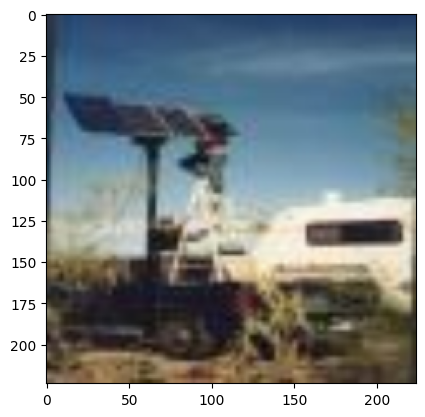

In [ ]:
# Get sample immage
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(iter(train_data_loader))
plt.imshow(np.transpose(images[1], (1, 2, 0)))
print(labels[1].item())

In [ ]:
min_pixel_value = torch.min(images[0])
max_pixel_value = torch.max(images[0])
print("Pixel Value Range: [{}, {}]".format(min_pixel_value, max_pixel_value))
mean_value = torch.mean(images[0])
std_deviation = torch.std(images[0])
print("Mean and std: [{}, {}]".format(mean_value, std_deviation))

# print(f'total number of images is {32*len(data_loader)}')

Pixel Value Range: [0.0, 1.0]
Mean and std: [0.43413010239601135, 0.22094067931175232]


## 1.2 Pretrain ResNet18 model on ImageNet

In [ ]:
# Donwloading ResNet18 model
resnet18 = torchvision.models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\dgonchar23/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# for name, param in resnet18.named_parameters():
#     print(f"{name}: Requires Grad - {param.requires_grad}")

In [ ]:
# Model train with 30 epoch

optimizer = torch.optim.Adam(resnet18.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

for epoch in range(30):
    bce_loss = nn.CrossEntropyLoss()
    resnet18.train()
    running_train_loss = 0.
    running_val_loss = 0.

    running_train_acc = 0.
    running_val_acc = 0.

    for i, data in enumerate(train_data_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        pred_labels = resnet18.forward(images)

        loss = bce_loss(pred_labels, labels)

        loss.backward()
        optimizer.step()

        running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
        running_train_loss += loss.item()


    resnet18.eval()
    for i, data in enumerate(val_data_loader):

        images_val, labels_val = data
        images_val, labels_val = images_val.to(device), labels_val.to(device)


        y_pred_labels = resnet18.forward(images_val)
        val_loss = bce_loss(y_pred_labels, labels_val)

        running_val_loss += val_loss
        running_val_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_val.detach().cpu().numpy())

    avg_train_loss = running_train_loss / len(train_data_loader)
    avg_val_loss = running_val_loss / len(val_data_loader)

    avg_train_acc = running_train_acc / len(train_data_loader)
    avg_val_acc = running_val_loss / len(val_data_loader)

    print(f'Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc} \n \
                            | Validation loss {avg_val_loss} | Validation Accuracy {avg_val_acc}')

Epoch 1 | Training Loss: 1.5190548323449635 | Training Accuracy 0.6434151785714286 
                             | Validation loss 0.889075756072998 | Validation Accuracy 0.889075756072998
Epoch 2 | Training Loss: 0.8662161051517441 | Training Accuracy 0.7642113095238096 
                             | Validation loss 0.7848823070526123 | Validation Accuracy 0.7848823070526123
Epoch 3 | Training Loss: 0.7658878141748053 | Training Accuracy 0.7825892857142858 
                             | Validation loss 0.7659931182861328 | Validation Accuracy 0.7659931182861328
Epoch 4 | Training Loss: 0.7133238522069795 | Training Accuracy 0.7981026785714286 
                             | Validation loss 0.7573645114898682 | Validation Accuracy 0.7573645114898682
Epoch 5 | Training Loss: 0.6808118347433352 | Training Accuracy 0.8034970238095238 
                             | Validation loss 0.8156846761703491 | Validation Accuracy 0.8156846761703491
Epoch 6 | Training Loss: 0.6525844637481939 | T

### Testing and evaluation

In [ ]:
resnet18.eval()

running_test_acc = 0.
running_test_loss = 0.

for i, data in enumerate(test_data_loader):
    images_test, labels_test = data
    images_test, labels_test = images_test.to(device), labels_test.to(device)

    y_pred_labels = resnet18.forward(images_test)
    test_loss = bce_loss(y_pred_labels, labels_test)

    running_test_loss += test_loss
    running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


avg_test_loss = running_test_loss / len(test_data_loader)
avg_test_acc = running_test_acc / len(test_data_loader)

print(f'Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

Test Loss: 0.9397718906402588 | Test Accuracy 0.7692708333333333


### Save the model

In [ ]:
torch.save(resnet18.state_dict(), 'resnet18_model.pt')

### Load the model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs

model = resnet18 # Initialize the model structure
model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))

model.eval() # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 1.3 Pretrain Vision Transformer model on ImageNet

### 1.3.1 Train on 30 epochs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')


In [ ]:
from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification

image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
vit = vit.to(device)

for param in vit.parameters():
    param.requires_grad = False

vit.classifier = nn.Linear(768,64).to(device) # Chaning final output layer to map our problem


C:\Users\Dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
for name, param in vit.named_parameters():
    print(f"{name}: Requires Grad - {param.requires_grad}")


vit.embeddings.cls_token: Requires Grad - False
vit.embeddings.position_embeddings: Requires Grad - False
vit.embeddings.patch_embeddings.projection.weight: Requires Grad - False
vit.embeddings.patch_embeddings.projection.bias: Requires Grad - False
vit.encoder.layer.0.attention.attention.query.weight: Requires Grad - False
vit.encoder.layer.0.attention.attention.query.bias: Requires Grad - False
vit.encoder.layer.0.attention.attention.key.weight: Requires Grad - False
vit.encoder.layer.0.attention.attention.key.bias: Requires Grad - False
vit.encoder.layer.0.attention.attention.value.weight: Requires Grad - False
vit.encoder.layer.0.attention.attention.value.bias: Requires Grad - False
vit.encoder.layer.0.attention.output.dense.weight: Requires Grad - False
vit.encoder.layer.0.attention.output.dense.bias: Requires Grad - False
vit.encoder.layer.0.intermediate.dense.weight: Requires Grad - False
vit.encoder.layer.0.intermediate.dense.bias: Requires Grad - False
vit.encoder.layer.0.outp

In [ ]:
optimizer = torch.optim.Adam(vit.parameters())

for epoch in range(30):
    bce_loss = nn.CrossEntropyLoss()
    vit.train()
    running_train_loss = 0.
    running_val_loss = 0.

    running_train_acc = 0.
    running_val_acc = 0.

    for i, data in enumerate(train_data_loader):
        images, labels = data
        images = list(images.unbind())  # Unbind the images tensor into a list of image tensors
        images = image_processor(images=images, do_normalize = False)
        images = torch.tensor(np.stack(images['pixel_values'], axis = 0))
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        pred_labels = vit.forward(images)

        loss = bce_loss(pred_labels[0], labels)

        loss.backward()
        optimizer.step()

        running_train_acc += get_acc(torch.argmax(pred_labels[0], dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
        running_train_loss += loss.item()


    vit.eval()
    for i, data in enumerate(val_data_loader):

        images_val, labels_val = data
        images_val = list(images_val.unbind())

        images_val = image_processor(images_val, do_normalize = False)
        images_val = torch.tensor(np.stack(images_val['pixel_values'], axis = 0))

        images_val, labels_val = images_val.to(device), labels_val.to(device)


        y_pred_labels = vit.forward(images_val)
        val_loss = bce_loss(y_pred_labels[0], labels_val)

        running_val_loss += val_loss
        running_val_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_val.detach().cpu().numpy())

    avg_train_loss = running_train_loss / len(train_data_loader)
    avg_val_loss = running_val_loss / len(val_data_loader)

    avg_train_acc = running_train_acc / len(train_data_loader)
    avg_val_acc = running_val_acc / len(val_data_loader)

    print(f'Epoch {epoch+1}: \nTraining Loss: {avg_train_loss} | Training Accuracy {avg_train_acc} \nValidation loss {avg_val_loss} | Validation Accuracy {avg_val_acc}')

Epoch 1: 
Training Loss: 0.3403508795760683 | Training Accuracy 0.9222098214285714 
Validation loss 0.21284125745296478 | Validation Accuracy 0.940625
Epoch 2: 
Training Loss: 0.12581108682262268 | Training Accuracy 0.9647321428571428 
Validation loss 0.2258845716714859 | Validation Accuracy 0.9381944444444444
Epoch 3: 
Training Loss: 0.07336552744631522 | Training Accuracy 0.9806547619047619 
Validation loss 0.23824287950992584 | Validation Accuracy 0.9357638888888888
Epoch 4: 
Training Loss: 0.04721137410635406 | Training Accuracy 0.9879092261904762 
Validation loss 0.2546827793121338 | Validation Accuracy 0.9362847222222223
Epoch 5: 
Training Loss: 0.03007040217468914 | Training Accuracy 0.993266369047619 
Validation loss 0.26733312010765076 | Validation Accuracy 0.9347222222222222
Epoch 6: 
Training Loss: 0.022052670196925257 | Training Accuracy 0.9956101190476191 
Validation loss 0.27509239315986633 | Validation Accuracy 0.9345486111111111
Epoch 7: 
Training Loss: 0.01671495323507

#### Testing and evaluation

In [ ]:
vit.eval()

running_test_acc = 0.
running_test_loss = 0.

for i, data in enumerate(test_data_loader):
    images_test, labels_test = data
    images_test = list(images_test.unbind())

    images_test = image_processor(images_test, do_normalize = False)
    images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))

    images_test, labels_test = images_test.to(device), labels_test.to(device)

    y_pred_labels = vit.forward(images_test)
    test_loss = bce_loss(y_pred_labels[0], labels_test)

    running_test_loss += test_loss
    running_test_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


avg_test_loss = running_test_loss / len(test_data_loader)
avg_test_acc = running_test_acc / len(test_data_loader)

print(f'Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

Test Loss: 0.46368536353111267 | Test Accuracy 0.9340277777777778


#### Save the model

In [ ]:
torch.save(vit.state_dict(), 'vit_model.pt')

#### Load the Model

In [ ]:
model = vit # Initialize the model structure
model.load_state_dict(torch.load('vit_model.pt', map_location=torch.device('cpu')))

model.eval() # Set the model to evaluation mode

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

### 1.3.2 Train on 5 epochs
better performance

In [ ]:
image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
vit = vit.to(device)

for param in vit.parameters():
    param.requires_grad = False

vit.classifier = nn.Linear(768,64).to(device) # Chaning final output layer to map our problem

model = vit # Initialize the model structure

model.load_state_dict(torch.load('vit_model_5ep.pt', map_location=torch.device('cpu')))
model.eval()

running_test_acc = 0.
running_test_loss = 0.
bce_loss = nn.CrossEntropyLoss()

for i, data in enumerate(test_data_loader):
    images_test, labels_test = data
    images_test = list(images_test.unbind())

    images_test = image_processor(images_test, do_normalize = False)
    images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))

    images_test, labels_test = images_test.to(device), labels_test.to(device)

    y_pred_labels = model.forward(images_test)
    test_loss = bce_loss(y_pred_labels[0], labels_test)

    running_test_loss += test_loss
    running_test_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


avg_test_loss = running_test_loss / len(test_data_loader)
avg_test_acc = running_test_acc / len(test_data_loader)

print(f'Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

Test Loss: 0.08907675743103027 | Test Accuracy 0.9791666666666666


### 1.3.3 Unexpected error
Same code, after running on local computer:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [ ]:
image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
vit = vit.to(device)

for param in vit.parameters():
    param.requires_grad = False

vit.classifier = nn.Linear(768,64).to(device) # Chaning final output layer to map our problem

model = vit # Initialize the model structure

model.load_state_dict(torch.load('vit_model_5ep.pt', map_location=torch.device('cpu')))
model.eval()

running_test_acc = 0.
running_test_loss = 0.
bce_loss = nn.CrossEntropyLoss()

for i, data in enumerate(test_data_loader):
    images_test, labels_test = data
    images_test = list(images_test.unbind())

    images_test = image_processor(images_test, do_normalize = False)
    images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))

    images_test, labels_test = images_test.to(device), labels_test.to(device)

    y_pred_labels = model.forward(images_test)
    test_loss = bce_loss(y_pred_labels[0], labels_test)

    running_test_loss += test_loss
    running_test_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


avg_test_loss = running_test_loss / len(test_data_loader)
avg_test_acc = running_test_acc / len(test_data_loader)

print(f'Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Test Loss: 5.474754810333252 | Test Accuracy 0.012152777777777778


# 1.4 Pretrain VGG16 model on ImageNet

In [8]:
# Extracting files from train folder

import tarfile
tar_file_path = 'train.tar'

with tarfile.open(tar_file_path, 'r') as tar:
  tar.extractall()

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

1.4.1 Class that saves the trained model that has the minimum loss

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, name='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.name = name
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.name)
        self.val_loss_min = val_loss

1.4.2 Evaluation and testing functions

In [6]:
# Evaluating

def eval(model, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()
    model.eval()
    correct = 0.0
    num_images = 0.0

    with torch.no_grad():

        for images, labels in data_loader:
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            outs = model(images)
    #         _, preds = outs.max(1)
            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum()
            num_images += len(labels)

    acc = correct / num_images
    return acc

# Training
def train(model, train_loader, valid_loader, optimizer, early_stopping, criterion, scheduler):

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    num_epochs = 25
    for epoch in range(num_epochs):

        model.train()

        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images

        for images, labels in train_loader:
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = outputs.argmax(dim=1)
            correct += predicted.eq(labels).sum()
            num_images += len(labels)

        # Learning rate scheduling step
        scheduler.step()

        # Evaluation on validation set
        acc = correct / num_images
        acc_eval = eval(model, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

        # Early stopping check
        early_stopping(loss.item(), model)

        if early_stopping.early_stop:
            print("Early stopping!")
            break

1.4.3 Function to train and test the model, save it with a chosen name and choose wheter to print the comments on EarlyStopping or not

In [7]:
import torch.optim as optim

def train_test_model(model, train_data_loader, val_data_loader, test_data_loader, name='checkpoint.pt', ver=False):

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  # Learning rate scheduling
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

  # Early stopping
  early_stopping = EarlyStopping(patience=5, verbose=ver, name=name)

  print('Please wait patiently, it may take some seconds...')

  # Train the network
  train(model, train_data_loader, val_data_loader, optimizer, early_stopping, criterion, scheduler)

  # Load the best model
  model.load_state_dict(torch.load(name))

  # Evaluation on test set
  acc_test = eval(model, test_data_loader)

  print(f'Accuracy on test set: {100 * acc_test}%')

  return acc_test

1.4.4 Train the VGG16 model with the Imagenet dataset

In [11]:
from torchvision.models import vgg16

# Define the model (VGG16 in this case)
model = vgg16(weights='IMAGENET1K_V1')
model.classifier[-1] = nn.Linear(4096, 64)  # Change the output layer to match the number of classes

train_test_model(model, train_data_loader, val_data_loader, test_data_loader, ver=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.0MB/s]


Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.001000, accuracy: 0.643638, loss: 1.057779, valid accuracy: 0.785417
Validation loss decreased (inf --> 1.057779).  Saving model ...
epoch: 1, lr: 0.001000, accuracy: 0.815216, loss: 0.627928, valid accuracy: 0.791840
Validation loss decreased (1.057779 --> 0.627928).  Saving model ...
epoch: 2, lr: 0.001000, accuracy: 0.869531, loss: 0.318309, valid accuracy: 0.805035
Validation loss decreased (0.627928 --> 0.318309).  Saving model ...
epoch: 3, lr: 0.001000, accuracy: 0.910565, loss: 0.219706, valid accuracy: 0.821701
Validation loss decreased (0.318309 --> 0.219706).  Saving model ...
epoch: 4, lr: 0.001000, accuracy: 0.938058, loss: 0.309031, valid accuracy: 0.819618
EarlyStopping counter: 1 out of 5
epoch: 5, lr: 0.001000, accuracy: 0.956548, loss: 0.142595, valid accuracy: 0.820139
Validation loss decreased (0.219706 --> 0.142595).  Saving model ...
epoch: 6, lr: 0.000100, accuracy: 0.963765, loss: 0.077985, valid

tensor(0.8497, device='cuda:0')

# 2. Fine Tuning

Compare the performance of different models (ResNet18, VGG, Vision Transformer, etc.), and investigate the different optimization strategies. (This part will be used as a bonus item, 2 points)

Used ResNet18, Vision Transformer,
<br>Ana: VGG

## 2.1 EuroSAT: ResNet18

### 2.1.1 EuroSAT: ResNet18 w & w/o augmentation

Trainging 2 resnet models, first on 5 EuroSat dataset. Another with data augmentation on 5 different datasets.
<br> Augmentation does not improve our accuracy. Next step - to try to add few more layers (like Norm and Linear) / unfreze more layers in model
<br> I Have downloaded EuroSat dataset from git repo and extracted it already, as python would take longer

Run 3 times below code.
<br>First attempt: With augmentation avg test accuracy is 0.864 and loss is 0.3875, Without augmentation avg test accuracy is 0.848 and loss is 0.445
<br>Second attempt: With augmentation avg test accuracy is 0.888 and loss is 0.3115, Without augmentation avg test accuracy is 0.872 and loss is 0.338
<br>Third attempt: With augmentation avg test accuracy is 0.896 and loss is 0.3237, Without augmentation avg test accuracy is 0.88 and loss is 0.321

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np

fin_test_loss = []
fin_test_acc = []

fin_test_loss_aug = []
fin_test_acc_aug = []

for i in range(5):

    # Option1:
#     transform = v2.Compose([
#     v2.Resize((224, 224)), # Resizing to 224x224
#     v2.ToTensor(), #moving to tensor
#     #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
#     ])

    # Option2:
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Resizing to 224x224
        transforms.ToTensor(), #moving to tensor
    ])
    dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


    stop = False
    images_arr = []
    labels_arr = []
    while not stop:## Iterating until stop is True

        batch = next(iter(dataset))# Getting batch of 32 images

        for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

            image = batch[0][imh_num]
            label = batch[1][imh_num].item()

            if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
                and len(labels_arr)<100:

                unique_values, counts = np.unique(labels_arr, return_counts=True)
                indx = np.where(unique_values == label)

                if counts[indx] < 20 or not np.isin(label, unique_values):

                    images_arr.append(image)
                    labels_arr.append(label)

            if len(labels_arr) == 100: # Once we reach 100 images we stop
                stop = True

    ## This is required as Model expects labels to have values starting with 0 if we want to use as final output less values than we had previosuly

    value_mapping = dict(zip(np.unique(labels_arr), range(0, len(np.unique(labels_arr)))))
    arr_mapped = np.vectorize(value_mapping.get)(labels_arr)

    ## If you want to test that its indeed generating each time unique image dataset change list(arr_mapped) to labels_arr.
    ## It will show images with original labels, but then model wont workS
    train_img, test_img, train_labels, test_labels = train_test_split(images_arr, list(arr_mapped), test_size = 0.25, random_state = 0, stratify = labels_arr)
    train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

    # Just checking for image visualization
    #images, labels = next(iter(train_data_loader))
    #plt.imshow(np.transpose(images[1], (1, 2, 0)))
    #print(labels[1].item())
    #plt.show()

    ## Loading the model each time for the training
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 features

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5)


    optimizer = torch.optim.Adam(model.parameters())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_data_loader)
        avg_train_acc = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc}')


    ## Evaluating model on train test to see our accuracy
    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

    fin_test_loss.append(avg_test_loss)
    fin_test_acc.append(avg_test_acc)


    ### Here starts model with data augmentation
    # Option1
#     transform = torch.nn.Sequential(
#     v2.RandomHorizontalFlip(p=0.5),
#     #v2.RandomZoomOut(p = 0.3),
#     #v2.RandomInvert(p = 0.3),
#     v2.ToTensor()
#     )

    # Option2
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    ## Preloading model same as in previous steps
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5)

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.001)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images = [transform(img) for img in images] ## Apply random transformation to images
            images = torch.stack(images)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss_aug = running_train_loss / len(train_data_loader)
        avg_train_acc_aug = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Augmented Training Loss: {avg_train_loss_aug} | Augmented Training Accuracy {avg_train_acc_aug}')


    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Augmented Test Loss: {avg_test_loss} | Augmented Test Accuracy {avg_test_acc}')

    fin_test_loss_aug.append(avg_test_loss)
    fin_test_acc_aug.append(avg_test_acc)

Dataset 1 | Epoch 10 | Training Loss: 0.6860550940036774 | Training Accuracy 0.7866666666666666
Dataset 1 | Epoch 20 | Training Loss: 0.396595906217893 | Training Accuracy 0.9333333333333333
Dataset 1 | Epoch 30 | Training Loss: 0.2566543345650037 | Training Accuracy 0.9600000000000002
Dataset 1 | Epoch 40 | Training Loss: 0.26598720575372375 | Training Accuracy 0.9066666666666667
Dataset 1 | Epoch 50 | Training Loss: 0.2608462671438853 | Training Accuracy 0.9066666666666666
Dataset 1 | Test Loss: 0.6153009533882141 | Test Accuracy 0.8400000000000001
Dataset 1 | Epoch 10 | Augmented Training Loss: 0.6792805254459381 | Augmented Training Accuracy 0.7733333333333334
Dataset 1 | Epoch 20 | Augmented Training Loss: 0.47035458087921145 | Augmented Training Accuracy 0.8800000000000001
Dataset 1 | Epoch 30 | Augmented Training Loss: 0.3927986979484558 | Augmented Training Accuracy 0.8933333333333333
Dataset 1 | Epoch 40 | Augmented Training Loss: 0.36764580979943273 | Augmented Training Accur

In [ ]:
# TEST WITH AUGMENTATION

fin_test_loss_aug = [x.item() for x in fin_test_loss_aug]
fin_test_loss = [x.item() for x in fin_test_loss]


print (f'With augmentation avg test accuracy is {np.mean(fin_test_acc_aug)} and loss is {np.mean(fin_test_loss_aug)}')
print (f'Without augmentation avg test accuracy is {np.mean(fin_test_acc)} and loss is {np.mean(fin_test_loss)}')

With augmentation avg test accuracy is 0.9199999999999999 and loss is 0.32931876480579375
Without augmentation avg test accuracy is 0.8640000000000001 and loss is 0.3960943937301636


### 2.1.2 EuroSAT: ResNet18 w & w/o freezing

No improvements. Things tried with below:
1. lr = 0.0001, weight_decay=0.01
2. lr = 0.001, weight_decay=0.01
3. lr = 0.001, weight_decay=0.001
4. lr = 0.0001, weight_decay=0.001
5. lr = 0.00001, weight_decay=0.00001
6. lr = 0.0001
7. lr = 0.00001
8. lr = 0.000001
9. lr = 0.1
<br>Some notes: big weight_decay and lr=0.00001 returned best reeslts, that were close to just basic model

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np

fin_test_loss = []
fin_test_acc = []

fin_test_loss_aug = []
fin_test_acc_aug = []

for i in range(5):

    # Option1:
#     transform = v2.Compose([
#     v2.Resize((224, 224)), # Resizing to 224x224
#     v2.ToTensor(), #moving to tensor
#     #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
#     ])

    # Option2:
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Resizing to 224x224
        transforms.ToTensor(), #moving to tensor
    ])

    dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


    stop = False
    images_arr = []
    labels_arr = []
    while not stop:## Iterating until stop is True

        batch = next(iter(dataset))# Getting batch of 32 images

        for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

            image = batch[0][imh_num]
            label = batch[1][imh_num].item()

            if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
                and len(labels_arr)<100:

                unique_values, counts = np.unique(labels_arr, return_counts=True)
                indx = np.where(unique_values == label)

                if counts[indx] < 20 or not np.isin(label, unique_values):

                    images_arr.append(image)
                    labels_arr.append(label)

            if len(labels_arr) == 100: # Once we reach 100 images we stop
                stop = True

    ## This is required as Model expects labels to have values starting with 0 if we want to use as final output less values than we had previosuly

    value_mapping = dict(zip(np.unique(labels_arr), range(0, len(np.unique(labels_arr)))))
    arr_mapped = np.vectorize(value_mapping.get)(labels_arr)

    ## If you want to test that its indeed generating each time unique image dataset change list(arr_mapped) to labels_arr.
    ## It will show images with original labels, but then model wont workS
    train_img, test_img, train_labels, test_labels = train_test_split(images_arr, list(arr_mapped), test_size = 0.25, random_state = 0, stratify = labels_arr)
    train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

    # Just checking for image visualization
    #images, labels = next(iter(train_data_loader))
    #plt.imshow(np.transpose(images[1], (1, 2, 0)))
    #print(labels[1].item())
    #plt.show()

## Loading the model each time for the training
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 features

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5)

    optimizer = torch.optim.Adam(model.parameters())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_data_loader)
        avg_train_acc = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc}')


    ## Evaluating model on train test to see our accuracy
    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

    fin_test_loss.append(avg_test_loss)
    fin_test_acc.append(avg_test_acc)


## Preloading model same as in previous steps
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5)

    for param in model.layer4.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.01)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(100):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss_aug = running_train_loss / len(train_data_loader)
        avg_train_acc_aug = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Unfreezed Training Loss: {avg_train_loss_aug} | Unfreezed Training Accuracy {avg_train_acc_aug}')


    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Unfreezed Test Loss: {avg_test_loss} | Unfreezed Test Accuracy {avg_test_acc}')

    fin_test_loss_aug.append(avg_test_loss)
    fin_test_acc_aug.append(avg_test_acc)

Dataset 1 | Epoch 10 | Training Loss: 0.6933428684870402 | Training Accuracy 0.8533333333333335
Dataset 1 | Epoch 20 | Training Loss: 0.5081756249070167 | Training Accuracy 0.7866666666666665
Dataset 1 | Epoch 30 | Training Loss: 0.30178268800179164 | Training Accuracy 0.92
Dataset 1 | Epoch 40 | Training Loss: 0.4228097826242447 | Training Accuracy 0.8533333333333333
Dataset 1 | Epoch 50 | Training Loss: 0.23922257944941522 | Training Accuracy 0.9600000000000002
Dataset 1 | Test Loss: 0.39154911041259766 | Test Accuracy 0.9199999999999999
Dataset 1 | Epoch 10 | Unfreezed Training Loss: 0.06992005884336928 | Unfreezed Training Accuracy 1.0
Dataset 1 | Epoch 20 | Unfreezed Training Loss: 0.03366510464499394 | Unfreezed Training Accuracy 1.0
Dataset 1 | Epoch 30 | Unfreezed Training Loss: 0.10164662295331557 | Unfreezed Training Accuracy 0.9733333333333334
Dataset 1 | Epoch 40 | Unfreezed Training Loss: 0.17664438548187414 | Unfreezed Training Accuracy 0.9333333333333333
Dataset 1 | Epoc

Dataset 5 | Epoch 70 | Unfreezed Training Loss: 0.1436296508841527 | Unfreezed Training Accuracy 0.9600000000000001
Dataset 5 | Epoch 80 | Unfreezed Training Loss: 0.015798903105314822 | Unfreezed Training Accuracy 1.0
Dataset 5 | Epoch 90 | Unfreezed Training Loss: 0.047279136312621026 | Unfreezed Training Accuracy 0.9866666666666667
Dataset 5 | Epoch 100 | Unfreezed Training Loss: 0.0448555547123154 | Unfreezed Training Accuracy 0.9866666666666667
Dataset 5 | Unfreezed Test Loss: 0.20235474407672882 | Unfreezed Test Accuracy 0.9199999999999999


In [ ]:
# WITH UNFREEZING V2

fin_test_loss_aug = [x for x in fin_test_loss_aug]
fin_test_loss = [x for x in fin_test_loss]


print (f'With Unfreezed layers avg test accuracy is {torch.mean(torch.tensor(fin_test_acc_aug))} and loss is {torch.mean(torch.tensor(fin_test_loss_aug))}')
print (f'Without Unfreezed layers avg test accuracy is {torch.mean(torch.tensor(fin_test_acc))} and loss is {torch.mean(torch.tensor(fin_test_loss))}')

With Unfreezed layers avg test accuracy is 0.944 and loss is 0.16222798824310303
Without Unfreezed layers avg test accuracy is 0.9119999999999999 and loss is 0.2784717381000519


### 2.1.3 EuroSAT: ResNet18 w & w/o freezing v2

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np

fin_test_loss = []
fin_test_acc = []

fin_test_loss_aug = []
fin_test_acc_aug = []


loss_results = []
acc_results = []

for i in range(5):

    # Option1:
#     transform = v2.Compose([
#     v2.Resize((224, 224)), # Resizing to 224x224
#     v2.ToTensor(), #moving to tensor
#     #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
#     ])

    # Option2:
    transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing to 224x224
    transforms.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
    ])

    dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


    stop = False
    images_arr = []
    labels_arr = []
    while not stop:## Iterating until stop is True

        batch = next(iter(dataset))# Getting batch of 32 images

        for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

            image = batch[0][imh_num]
            label = batch[1][imh_num].item()

            if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
                and len(labels_arr)<100:

                unique_values, counts = np.unique(labels_arr, return_counts=True)
                indx = np.where(unique_values == label)

                if counts[indx] < 20 or not np.isin(label, unique_values):

                    images_arr.append(image)
                    labels_arr.append(label)

            if len(labels_arr) == 100: # Once we reach 100 images we stop
                stop = True

    ## This is required as Model expects labels to have values starting with 0 if we want to use as final output less values than we had previosuly

    value_mapping = dict(zip(np.unique(labels_arr), range(0, len(np.unique(labels_arr)))))
    arr_mapped = np.vectorize(value_mapping.get)(labels_arr)

    ## If you want to test that its indeed generating each time unique image dataset change list(arr_mapped) to labels_arr.
    ## It will show images with original labels, but then model wont workS
    train_img, test_img, train_labels, test_labels = train_test_split(images_arr, list(arr_mapped), test_size = 0.25, random_state = 0, stratify = labels_arr)
    train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

    # Just checking for image visualization
    #images, labels = next(iter(train_data_loader))
    #plt.imshow(np.transpose(images[1], (1, 2, 0)))
    #print(labels[1].item())
    #plt.show()

    ## Loading the model each time for the training
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 features

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5)

    optimizer = torch.optim.Adam(model.parameters())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_data_loader)
        avg_train_acc = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc}')


    ## Evaluating model on train test to see our accuracy
    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

    fin_test_loss.append(avg_test_loss)
    fin_test_acc.append(avg_test_acc)


## Preloading model same as in previous steps
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5)

    for param in model.layer4.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.000001,
                                 #weight_decay=0.00001)
                                )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    ls = []
    ac = []

    for epoch in range(150):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()


        avg_train_loss_aug = running_train_loss / len(train_data_loader)
        avg_train_acc_aug = running_train_acc / len(train_data_loader)

        ls.append(avg_train_loss_aug)
        ac.append(avg_train_acc_aug)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Unfreezed Training Loss: {avg_train_loss_aug} | Unfreezed Training Accuracy {avg_train_acc_aug}')

    loss_results.append(ls)
    acc_results.append(ac)

    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Unfreezed Test Loss: {avg_test_loss} | Unfreezed Test Accuracy {avg_test_acc}')

    fin_test_loss_aug.append(avg_test_loss)
    fin_test_acc_aug.append(avg_test_acc)

Dataset 1 | Epoch 10 | Training Loss: 0.5608939945697784 | Training Accuracy 0.8133333333333334
Dataset 1 | Epoch 20 | Training Loss: 0.42408994138240813 | Training Accuracy 0.9066666666666667
Dataset 1 | Epoch 30 | Training Loss: 0.33352275788784025 | Training Accuracy 0.9066666666666666
Dataset 1 | Epoch 40 | Training Loss: 0.29139218827088675 | Training Accuracy 0.92
Dataset 1 | Epoch 50 | Training Loss: 0.20674103274941444 | Training Accuracy 0.9600000000000001
Dataset 1 | Test Loss: 0.1793377697467804 | Test Accuracy 0.96
Dataset 1 | Epoch 10 | Unfreezed Training Loss: 1.4803040345509848 | Unfreezed Training Accuracy 0.36000000000000004
Dataset 1 | Epoch 20 | Unfreezed Training Loss: 1.293644920984904 | Unfreezed Training Accuracy 0.4666666666666667
Dataset 1 | Epoch 30 | Unfreezed Training Loss: 1.115692150592804 | Unfreezed Training Accuracy 0.6133333333333334
Dataset 1 | Epoch 40 | Unfreezed Training Loss: 0.9903124292691549 | Unfreezed Training Accuracy 0.7600000000000001
Data

Dataset 4 | Epoch 60 | Unfreezed Training Loss: 0.7947090943654378 | Unfreezed Training Accuracy 0.7466666666666666
Dataset 4 | Epoch 70 | Unfreezed Training Loss: 0.7575373391310374 | Unfreezed Training Accuracy 0.8133333333333334
Dataset 4 | Epoch 80 | Unfreezed Training Loss: 0.687869789203008 | Unfreezed Training Accuracy 0.8400000000000001
Dataset 4 | Epoch 90 | Unfreezed Training Loss: 0.613182270526886 | Unfreezed Training Accuracy 0.8933333333333333
Dataset 4 | Epoch 100 | Unfreezed Training Loss: 0.4827963640292486 | Unfreezed Training Accuracy 0.9466666666666668
Dataset 4 | Epoch 110 | Unfreezed Training Loss: 0.41946218609809877 | Unfreezed Training Accuracy 0.9600000000000001
Dataset 4 | Epoch 120 | Unfreezed Training Loss: 0.42937727669874826 | Unfreezed Training Accuracy 0.92
Dataset 4 | Epoch 130 | Unfreezed Training Loss: 0.46991870005925496 | Unfreezed Training Accuracy 0.8933333333333333
Dataset 4 | Epoch 140 | Unfreezed Training Loss: 0.4357589448491732 | Unfreezed T

In [ ]:
# WITH UNFREEZING V2

fin_test_loss_aug = [x for x in fin_test_loss_aug]
fin_test_loss = [x for x in fin_test_loss]


print (f'With Unfreezed layers avg test accuracy is {torch.mean(torch.tensor(fin_test_acc_aug))} and loss is {torch.mean(torch.tensor(fin_test_loss_aug))}')
print (f'Without Unfreezed layers avg test accuracy is {torch.mean(torch.tensor(fin_test_acc))} and loss is {torch.mean(torch.tensor(fin_test_loss))}')

With Unfreezed layers avg test accuracy is 0.8640000000000001 and loss is 0.47819074988365173
Without Unfreezed layers avg test accuracy is 0.8640000000000001 and loss is 0.34972018003463745


### 2.1.4 EuroSAT: ResNet18 w & w/o changed optimizer, introduction of Step Learner and unfrozen 3rd and 4th layers

This has yelded the best result with on average 5% improvement in accuracy

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
from torch.optim import lr_scheduler

fin_test_loss = []
fin_test_acc = []

fin_test_loss_aug = []
fin_test_acc_aug = []


loss_results = []
acc_results = []

for i in range(5):

    # Option1:
#     transform = v2.Compose([
#     v2.Resize((224, 224)), # Resizing to 224x224
#     v2.ToTensor(), #moving to tensor
#     #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
#     ])

    # Option2:
    transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing to 224x224
    transforms.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
    ])

    dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


    stop = False
    images_arr = []
    labels_arr = []
    while not stop:## Iterating until stop is True

        batch = next(iter(dataset))# Getting batch of 32 images

        for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

            image = batch[0][imh_num]
            label = batch[1][imh_num].item()

            if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
                and len(labels_arr)<100:

                unique_values, counts = np.unique(labels_arr, return_counts=True)
                indx = np.where(unique_values == label)

                if counts[indx] < 20 or not np.isin(label, unique_values):

                    images_arr.append(image)
                    labels_arr.append(label)

            if len(labels_arr) == 100: # Once we reach 100 images we stop
                stop = True

    ## This is required as Model expects labels to have values starting with 0 if we want to use as final output less values than we had previosuly

    value_mapping = dict(zip(np.unique(labels_arr), range(0, len(np.unique(labels_arr)))))
    arr_mapped = np.vectorize(value_mapping.get)(labels_arr)

    ## If you want to test that its indeed generating each time unique image dataset change list(arr_mapped) to labels_arr.
    ## It will show images with original labels, but then model wont workS
    train_img, test_img, train_labels, test_labels = train_test_split(images_arr, list(arr_mapped), test_size = 0.25, random_state = 0, stratify = labels_arr)
    train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

    # Just checking for image visualization
    #images, labels = next(iter(train_data_loader))
    #plt.imshow(np.transpose(images[1], (1, 2, 0)))
    #print(labels[1].item())
    #plt.show()

    ## Loading the model each time for the training
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 features

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5)

    optimizer = torch.optim.Adam(model.parameters())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_data_loader)
        avg_train_acc = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc}')


    ## Evaluating model on train test to see our accuracy
    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')
    print('-'*110)

    fin_test_loss.append(avg_test_loss)
    fin_test_acc.append(avg_test_acc)


    ## Preloading model same as in previous steps
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5)

    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True

    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9
                                )

    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    ls = []
    ac = []

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        scheduler.step()
        avg_train_loss_aug = running_train_loss / len(train_data_loader)
        avg_train_acc_aug = running_train_acc / len(train_data_loader)

        ls.append(avg_train_loss_aug)
        ac.append(avg_train_acc_aug)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Unfreezed Training Loss: {avg_train_loss_aug} | Unfreezed Training Accuracy {avg_train_acc_aug}')

    loss_results.append(ls)
    acc_results.append(ac)

    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Unfreezed Test Loss: {avg_test_loss} | Unfreezed Test Accuracy {avg_test_acc}')
    print('-'*120)

    fin_test_loss_aug.append(avg_test_loss)
    fin_test_acc_aug.append(avg_test_acc)

Dataset 1 | Epoch 10 | Training Loss: 0.5997679630915324 | Training Accuracy 0.8533333333333333
Dataset 1 | Epoch 20 | Training Loss: 0.4216290255387624 | Training Accuracy 0.8666666666666667
Dataset 1 | Epoch 30 | Training Loss: 0.24203631492952507 | Training Accuracy 0.9333333333333333
Dataset 1 | Epoch 40 | Training Loss: 0.2893396593630314 | Training Accuracy 0.92
Dataset 1 | Epoch 50 | Training Loss: 0.3613928941388925 | Training Accuracy 0.8800000000000001
Dataset 1 | Test Loss: 0.6446877121925354 | Test Accuracy 0.8800000000000001
--------------------------------------------------------------------------------------------------------------
Dataset 1 | Epoch 10 | Unfreezed Training Loss: 0.05467582304651539 | Unfreezed Training Accuracy 1.0
Dataset 1 | Epoch 20 | Unfreezed Training Loss: 0.09423513460593919 | Unfreezed Training Accuracy 0.9733333333333333
Dataset 1 | Epoch 30 | Unfreezed Training Loss: 0.15510200311740238 | Unfreezed Training Accuracy 0.9599999999999999
Dataset 1

In [ ]:
fin_test_loss_aug = [x.item() for x in fin_test_loss_aug]
fin_test_loss = [x.item() for x in fin_test_loss]


print (f'With Changed optimizer avg test accuracy is {np.mean(fin_test_acc_aug)} and loss is {np.mean(fin_test_loss_aug)}')
print (f'Without Changed optimizer avg test accuracy is {np.mean(fin_test_acc)} and loss is {np.mean(fin_test_loss)}')

With Changed optimizer avg test accuracy is 0.9119999999999999 and loss is 0.2984041914343834
Without Changed optimizer avg test accuracy is 0.8960000000000001 and loss is 0.36610778868198396


### 2.1.6 EuroSAT: Comparisson of just augmentation and unfrozen 3rd and 4th layer

In [127]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np

fin_test_loss = []
fin_test_acc = []


fin_test_loss_aug = []
fin_test_acc_aug = []

viz_loss_results_aug = []
viz_acc_results_aug = []

viz_loss_results_unfr = []
viz_acc_results_unfr = []

for i in range(5):

    # Option1:
#     transform = v2.Compose([
#     v2.Resize((224, 224)), # Resizing to 224x224
#     v2.ToTensor(), #moving to tensor
#     #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as 
#     RandomHorizontalFlip(p=0.5)
#     ])
    
    # Option2:
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((224, 224)), # Resizing to 224x224
        transforms.ToTensor(), #moving to tensor
    ])
    
    dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


    stop = False
    images_arr = []
    labels_arr = []
    while not stop:## Iterating until stop is True

        batch = next(iter(dataset))# Getting batch of 32 images

        for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

            image = batch[0][imh_num] 
            label = batch[1][imh_num].item()

            if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
                and len(labels_arr)<100:

                unique_values, counts = np.unique(labels_arr, return_counts=True)
                indx = np.where(unique_values == label)

                if counts[indx] < 20 or not np.isin(label, unique_values):

                    images_arr.append(image)
                    labels_arr.append(label)

            if len(labels_arr) == 100: # Once we reach 100 images we stop
                stop = True

    ## This is required as Model expects labels to have values starting with 0 if we want to use as final output less values than we had previosuly

    value_mapping = dict(zip(np.unique(labels_arr), range(0, len(np.unique(labels_arr)))))
    arr_mapped = np.vectorize(value_mapping.get)(labels_arr)

    ## If you want to test that its indeed generating each time unique image dataset change list(arr_mapped) to labels_arr.
    ## It will show images with original labels, but then model wont workS
    train_img, test_img, train_labels, test_labels = train_test_split(images_arr, list(arr_mapped), test_size = 0.75, random_state = 0, stratify = labels_arr)
    train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

    # Just checking for image visualization
    #images, labels = next(iter(train_data_loader))
    #plt.imshow(np.transpose(images[1], (1, 2, 0)))
    #print(labels[1].item())
    #plt.show()

## Loading the model each time for the training
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 features

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5) 

    optimizer = torch.optim.Adam(model.parameters())
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_data_loader)
        avg_train_acc = running_train_acc / len(train_data_loader)

        viz_acc_results_aug.append(avg_train_acc)
        viz_loss_results_aug.append(avg_train_loss)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Augmentation Training Loss: {avg_train_loss} | Augmentation Training Accuracy {avg_train_acc}')


    ## Evaluating model on train test to see our accuracy
    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.
    
    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)
    
        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)
    
        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())
        
        
    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)
    
    print(f'Dataset {i+1} | Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

    fin_test_loss.append(avg_test_loss)
    fin_test_acc.append(avg_test_acc)


## Preloading model same as in previous steps
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs

    model = resnet18 # Initialize the model structure
    model.load_state_dict(torch.load('resnet18_model.pt', map_location=torch.device('cpu')))
    model.fc = nn.Linear(512, 5) 

    for param in model.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.01)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss_aug = running_train_loss / len(train_data_loader)
        avg_train_acc_aug = running_train_acc / len(train_data_loader)

        viz_acc_results_unfr.append(avg_train_acc)
        viz_loss_results_unfr.append(avg_train_loss)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Unfreezed Training Loss: {avg_train_loss_aug} | Unfreezed Training Accuracy {avg_train_acc_aug}')


    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.
    
    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test, labels_test = images_test.to(device), labels_test.to(device)
    
        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels, labels_test)
    
        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())
        
        
    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)
    
    print(f'Dataset {i+1} | Unfreezed Test Loss: {avg_test_loss} | Unfreezed Test Accuracy {avg_test_acc}')

    fin_test_loss_aug.append(avg_test_loss)
    fin_test_acc_aug.append(avg_test_acc)

Dataset 1 | Epoch 10 | Augmentation Training Loss: 0.6836398005485534 | Augmentation Training Accuracy 0.96
Dataset 1 | Epoch 20 | Augmentation Training Loss: 0.3908695101737976 | Augmentation Training Accuracy 1.0
Dataset 1 | Epoch 30 | Augmentation Training Loss: 0.24263390004634858 | Augmentation Training Accuracy 1.0
Dataset 1 | Epoch 40 | Augmentation Training Loss: 0.19705747216939926 | Augmentation Training Accuracy 0.96
Dataset 1 | Epoch 50 | Augmentation Training Loss: 0.1356564536690712 | Augmentation Training Accuracy 1.0
Dataset 1 | Test Loss: 0.43213602900505066 | Test Accuracy 0.8800000000000002
Dataset 1 | Epoch 10 | Unfreezed Training Loss: 0.03457443714141846 | Unfreezed Training Accuracy 1.0
Dataset 1 | Epoch 20 | Unfreezed Training Loss: 0.0068966076942160726 | Unfreezed Training Accuracy 1.0
Dataset 1 | Epoch 30 | Unfreezed Training Loss: 0.051993082836270334 | Unfreezed Training Accuracy 1.0
Dataset 1 | Epoch 40 | Unfreezed Training Loss: 0.01307080234400928 | Unfr

In [128]:
fin_test_loss_aug = [x.item() for x in fin_test_loss_aug]
fin_test_loss = [x.item() for x in fin_test_loss]


print (f'With Unfreeze and changed optimizer avg test accuracy is {np.mean(fin_test_acc_aug)} and loss is {np.mean(fin_test_loss_aug)}')
print (f'With Augmentation avg test accuracy is {np.mean(fin_test_acc)} and loss is {np.mean(fin_test_loss)}')

With Unfreeze and changed optimizer avg test accuracy is 0.7546666666666666 and loss is 0.6720568716526032
With Augmentation avg test accuracy is 0.8293333333333335 and loss is 0.5324380218982696


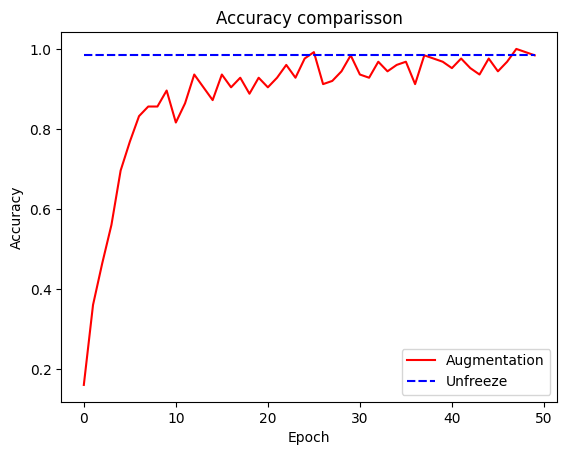

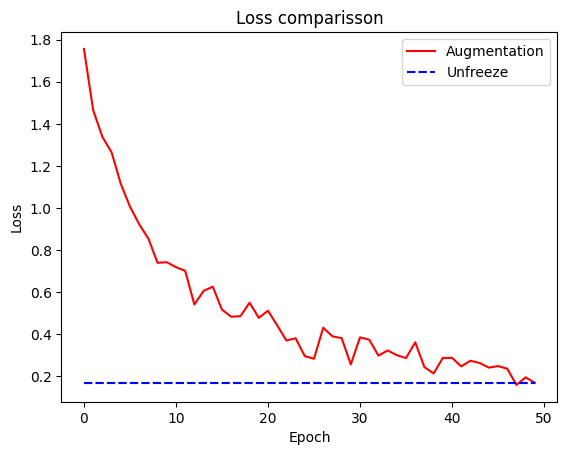

In [129]:
## Vizualizing the loss and accuracy
import seaborn as sns
import pandas as pd

viz_acc_aug = []
viz_acc_unf = []

viz_loss_aug = []
viz_loss_unf = []

for i in range(50):
    viz_acc_aug.append(np.mean([viz_acc_results_aug[i], viz_acc_results_aug[i+50], viz_acc_results_aug[i+100],
                           viz_acc_results_aug[i+150], viz_acc_results_aug[i+200]]))
    
    viz_acc_unf.append(np.mean([viz_acc_results_unfr[i], viz_acc_results_unfr[i+50], viz_acc_results_unfr[i+100],
                           viz_acc_results_unfr[i+150], viz_acc_results_unfr[i+200]]))
    
    
    viz_loss_unf.append(np.mean([viz_loss_results_unfr[i], viz_loss_results_unfr[i+50], viz_loss_results_unfr[i+100],
                           viz_loss_results_unfr[i+150], viz_loss_results_unfr[i+200]]))
    
    viz_loss_aug.append(np.mean([viz_loss_results_aug[i], viz_loss_results_aug[i+50], viz_loss_results_aug[i+100],
                           viz_loss_results_aug[i+150], viz_loss_results_aug[i+200]]))
    
    
sns.lineplot(pd.DataFrame(np.column_stack([viz_acc_aug,viz_acc_unf]), columns = ['Augmentation', 'Unfreeze']), palette=['red', 'blue'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy comparisson')
plt.show()

sns.lineplot(pd.DataFrame(np.column_stack([viz_loss_aug,viz_loss_unf]), columns = ['Augmentation', 'Unfreeze']), palette=['red', 'blue'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss comparisson')
plt.show()

## 2.2 EuroSAT: VIT

### 2.2.1 EuroSAT: VIT w and w/o augmentation

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification

fin_test_loss = []
fin_test_acc = []

fin_test_loss_aug = []
fin_test_acc_aug = []


loss_results = []
acc_results = []

# fine-tuning 5 times on different 100 EuroSAT images
for i in range(5):

    # Option1:
#     transform = v2.Compose([
#     v2.Resize((224, 224)), # Resizing to 224x224
#     v2.ToTensor(), #moving to tensor
#     #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
#     ])

    # Option2:
    transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing to 224x224
    transforms.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
    ])

    dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    # Choose 100 images from EuroSAT dataset
    # 25 samples for 5 categories
    stop = False
    images_arr = []
    labels_arr = []
    while not stop:## Iterating until stop is True

        batch = next(iter(dataset))# Getting batch of 32 images

        for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

            image = batch[0][imh_num]
            label = batch[1][imh_num].item()

            if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
                and len(labels_arr)<100:

                unique_values, counts = np.unique(labels_arr, return_counts=True)
                indx = np.where(unique_values == label)

                if counts[indx] < 20 or not np.isin(label, unique_values):

                    images_arr.append(image)
                    labels_arr.append(label)

            if len(labels_arr) == 100: # Once we reach 100 images we stop
                stop = True

    ## This is required as Model expects labels to have values starting with 0 if we want to use as final output less values than we had previosuly

    value_mapping = dict(zip(np.unique(labels_arr), range(0, len(np.unique(labels_arr)))))
    arr_mapped = np.vectorize(value_mapping.get)(labels_arr)

    # Randomly choose 25 images as training set
    # 5 images for 5 categories

    ## If you want to test that its indeed generating each time unique image dataset change list(arr_mapped) to labels_arr.
    ## It will show images with original labels, but then model wont workS
    train_img, test_img, train_labels, test_labels = train_test_split(images_arr, list(arr_mapped), test_size = 0.75, random_state = 0, stratify = labels_arr)
    train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

    # Just checking for image visualization
    #images, labels = next(iter(train_data_loader))
    #plt.imshow(np.transpose(images[1], (1, 2, 0)))
    #print(labels[1].item())
    #plt.show()

## Loading the model each time for the training
    image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
    vit = vit.to(device)

    for param in vit.parameters():
        param.requires_grad = False

    vit.classifier = nn.Linear(768,64) # Chaning final output layer to map our problem

    model = vit # Initialize the model structure
    model.load_state_dict(torch.load('vit_model.pt', map_location=torch.device('cpu')))
    model.classifier = nn.Linear(768, 5)

    optimizer = torch.optim.Adam(model.parameters())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images = list(images.unbind())  # Unbind the images tensor into a list of image tensors
            images = image_processor(images=images, do_normalize = False)
            images = torch.tensor(np.stack(images['pixel_values'], axis = 0))
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels[0], labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels[0], dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_data_loader)
        avg_train_acc = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc}')

    # Test model on the rest 75 samples
    # Show results

    ## Evaluating model on train test to see our accuracy
    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test = list(images_test.unbind())  # Unbind the images tensor into a list of image tensors
        images_test = image_processor(images=images_test, do_normalize = False)
        images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels[0], labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

    fin_test_loss.append(avg_test_loss)
    fin_test_acc.append(avg_test_acc)

### Here starts model with data augmentation

    # Option1
#     transform = torch.nn.Sequential(
#     v2.RandomHorizontalFlip(p=0.5),
#     #v2.RandomZoomOut(p = 0.3),
#     #v2.RandomInvert(p = 0.3),
#     v2.ToTensor()
#     )

    # Option2
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    ## Preloading model same as in previous steps
    ## Loading the model each time for the training
    image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
    vit = vit.to(device)

    for param in vit.parameters():
        param.requires_grad = False

    vit.classifier = nn.Linear(768,64) # Chaning final output layer to map our problem

    model = vit # Initialize the model structure
    model.load_state_dict(torch.load('vit_model.pt', map_location=torch.device('cpu')))
    model.classifier = nn.Linear(768, 5)

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.001)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images = [transform(img) for img in images] ## Apply random transformation to images
            images = torch.stack(images)
            images = list(images.unbind())  # Unbind the images tensor into a list of image tensors
            images = image_processor(images=images, do_normalize = False)
            images = torch.tensor(np.stack(images['pixel_values'], axis = 0))
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels[0], labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels[0], dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss_aug = running_train_loss / len(train_data_loader)
        avg_train_acc_aug = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Augmented Training Loss: {avg_train_loss_aug} | Augmented Training Accuracy {avg_train_acc_aug}')


    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test = list(images_test.unbind())  # Unbind the images tensor into a list of image tensors
        images_test = image_processor(images=images_test, do_normalize = False)
        images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels[0], labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Augmented Test Loss: {avg_test_loss} | Augmented Test Accuracy {avg_test_acc}')

    fin_test_loss_aug.append(avg_test_loss)
    fin_test_acc_aug.append(avg_test_acc)

Dataset 1 | Epoch 10 | Training Loss: 0.36430183400710425 | Training Accuracy 0.8933333333333332
Dataset 1 | Epoch 20 | Training Loss: 0.04149418100714684 | Training Accuracy 1.0
Dataset 1 | Epoch 30 | Training Loss: 0.019713115443785987 | Training Accuracy 1.0
Dataset 1 | Epoch 40 | Training Loss: 0.012345898694669207 | Training Accuracy 1.0
Dataset 1 | Epoch 50 | Training Loss: 0.008643029956147075 | Training Accuracy 1.0
Dataset 1 | Test Loss: 0.3670055866241455 | Test Accuracy 0.8800000000000001
Dataset 1 | Epoch 10 | Augmented Training Loss: 0.3979152473310629 | Augmented Training Accuracy 0.8666666666666667
Dataset 1 | Epoch 20 | Augmented Training Loss: 0.05069485877950986 | Augmented Training Accuracy 1.0
Dataset 1 | Epoch 30 | Augmented Training Loss: 0.02097157374955714 | Augmented Training Accuracy 1.0
Dataset 1 | Epoch 40 | Augmented Training Loss: 0.011148336258096 | Augmented Training Accuracy 1.0
Dataset 1 | Epoch 50 | Augmented Training Loss: 0.010555509920231998 | Augm

In [ ]:
# VIT TEST WITH AUGMENTATION

# Get the average result of fine-tuned model trained on 5 datasets

fin_test_loss_aug = [x.item() for x in fin_test_loss_aug]
fin_test_loss = [x.item() for x in fin_test_loss]


print (f'With augmentation avg test accuracy is {np.mean(fin_test_acc_aug)} and loss is {np.mean(fin_test_loss_aug)}')
print (f'Without augmentation avg test accuracy is {np.mean(fin_test_acc)} and loss is {np.mean(fin_test_loss)}')

With augmentation avg test accuracy is 0.808 and loss is 0.8606345146894455
Without augmentation avg test accuracy is 0.784 and loss is 0.9464485049247742


### 2.2.2 EuroSAT: ViT w & w/o changed optimizer: Adam vs SGD, Step Learner, Unfrozen layers

Adam >> SGD

Adam >> SGD + sched

Adam >> RMS

Adam > Adam + sched

Adam 3 layers >> Adam 2 layers

Adam 50 eps > Adam 150 eps >> Adam 10 eps

ViT 5 eps > ViT 30 eps (Not always the case)

Adam ViT 30 ep VS Adam ViT 5 ep:

1. run: acc 0.848 loss 0.7632 VS acc 0.920 loss 0.3616
2. run: acc 0.952 loss 0.4305 VS acc 0.936 loss 0.2901
3. run: acc 0.872 loss 1.0439 VS acc 0.887 loss 0.5506

In [ ]:
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification

fin_test_loss = []
fin_test_acc = []

fin_test_loss_aug = []
fin_test_acc_aug = []


loss_results = []
acc_results = []

# fine-tuning 5 times on different 100 EuroSAT images
for i in range(5):

    # Option2:
    transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing to 224x224
    transforms.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
    ])

    dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    # Choose 100 images from EuroSAT dataset
    # 25 samples for 5 categories
    stop = False
    images_arr = []
    labels_arr = []
    while not stop:## Iterating until stop is True

        batch = next(iter(dataset))# Getting batch of 32 images

        for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

            image = batch[0][imh_num]
            label = batch[1][imh_num].item()

            if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
                and len(labels_arr)<100:

                unique_values, counts = np.unique(labels_arr, return_counts=True)
                indx = np.where(unique_values == label)

                if counts[indx] < 20 or not np.isin(label, unique_values):

                    images_arr.append(image)
                    labels_arr.append(label)

            if len(labels_arr) == 100: # Once we reach 100 images we stop
                stop = True

    ## This is required as Model expects labels to have values starting with 0 if we want to use as final output less values than we had previosuly

    value_mapping = dict(zip(np.unique(labels_arr), range(0, len(np.unique(labels_arr)))))
    arr_mapped = np.vectorize(value_mapping.get)(labels_arr)

    # Randomly choose 25 images as training set
    # 5 images for 5 categories

    train_img, test_img, train_labels, test_labels = train_test_split(images_arr, list(arr_mapped), test_size = 0.75, random_state = 0, stratify = labels_arr)
    train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

## Model with SGD & Scheduler; Unfrozen 3 layers; ViT 30 epochs
    ## Loading the model each time for the training
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
    vit = vit.to(device)

    for param in vit.parameters():
        param.requires_grad = False

    vit.classifier = nn.Linear(768,64) # Chaning final output layer to map our problem

    model = vit # Initialize the model structure
    model.load_state_dict(torch.load('vit_model_5ep.pt', map_location=torch.device('cpu')))

    ## Unfreeze layer 9, 10, and 11:
    for name, param in model.named_parameters():
        if 'encoder.layer.9' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name:
            param.requires_grad = True

    model.classifier = nn.Linear(768, 5)

    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9
                                )

    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images = [transform(img) for img in images] ## Apply random transformation to images
            images = torch.stack(images)
            images = list(images.unbind())  # Unbind the images tensor into a list of image tensors
            images = image_processor(images=images, do_normalize = False)
            images = torch.tensor(np.stack(images['pixel_values'], axis = 0))
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels[0], labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels[0], dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_train_loss / len(train_data_loader)
        avg_train_acc = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | SGD Training Loss: {avg_train_loss} | SGD Training Accuracy {avg_train_acc}')

    # Test model on the rest 75 samples
    # Show results

    ## Evaluating model on train test to see our accuracy
    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test = list(images_test.unbind())  # Unbind the images tensor into a list of image tensors
        images_test = image_processor(images=images_test, do_normalize = False)
        images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels[0], labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | SGD Test Loss: {avg_test_loss} | SGD Test Accuracy {avg_test_acc}')
    print('-'*110)

    fin_test_loss.append(avg_test_loss)
    fin_test_acc.append(avg_test_acc)

### Here starts model Adam; Unfrozen 3 layers; ViT 5 epochs

    # Option2
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    ## Preloading model same as in previous steps
    ## Loading the model each time for the training
    image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
    vit = vit.to(device)

    for param in vit.parameters():
        param.requires_grad = False

    vit.classifier = nn.Linear(768,64) # Chaning final output layer to map our problem

    model = vit # Initialize the model structure
    model.load_state_dict(torch.load('vit_model_5ep.pt', map_location=torch.device('cpu')))

    ## Unfreeze layer 9, 10, and 11:
    for name, param in model.named_parameters():
        if 'encoder.layer.9' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name:
            param.requires_grad = True

    model.classifier = nn.Linear(768, 5)

    optimizer = torch.optim.Adam(model.parameters())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    ls = []
    ac = []

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images = [transform(img) for img in images] ## Apply random transformation to images
            images = torch.stack(images)
            images = list(images.unbind())  # Unbind the images tensor into a list of image tensors
            images = image_processor(images=images, do_normalize = False)
            images = torch.tensor(np.stack(images['pixel_values'], axis = 0))
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)
            pred_labels = pred_labels[0]

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss_aug = running_train_loss / len(train_data_loader)
        avg_train_acc_aug = running_train_acc / len(train_data_loader)

        ls.append(avg_train_loss_aug)
        ac.append(avg_train_acc_aug)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Adam Training Loss: {avg_train_loss_aug} | Adam Training Accuracy {avg_train_acc_aug}')

    loss_results.append(ls)
    acc_results.append(ac)

    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test = list(images_test.unbind())  # Unbind the images tensor into a list of image tensors
        images_test = image_processor(images=images_test, do_normalize = False)
        images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        y_pred_labels = y_pred_labels[0]
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Adam Test Loss: {avg_test_loss} | Adam Test Accuracy {avg_test_acc}')
    print('-'*125)

    fin_test_loss_aug.append(avg_test_loss)
    fin_test_acc_aug.append(avg_test_acc)

Dataset 1 | Epoch 10 | SGD Training Loss: 0.007524559297598899 | SGD Training Accuracy 1.0
Dataset 1 | Epoch 20 | SGD Training Loss: 0.005961211794055998 | SGD Training Accuracy 1.0
Dataset 1 | Epoch 30 | SGD Training Loss: 0.00586177078075707 | SGD Training Accuracy 1.0
Dataset 1 | Epoch 40 | SGD Training Loss: 0.005857049805733065 | SGD Training Accuracy 1.0
Dataset 1 | Epoch 50 | SGD Training Loss: 0.005855523911304772 | SGD Training Accuracy 1.0
Dataset 1 | SGD Test Loss: 0.3502943217754364 | SGD Test Accuracy 0.8799999999999999
--------------------------------------------------------------------------------------------------------------
Dataset 1 | Epoch 10 | Adam Training Loss: 3.8546564269381633e-05 | Adam Training Accuracy 1.0
Dataset 1 | Epoch 20 | Adam Training Loss: 6.54836337995827e-06 | Adam Training Accuracy 1.0
Dataset 1 | Epoch 30 | Adam Training Loss: 7.184334255801635e-07 | Adam Training Accuracy 1.0
Dataset 1 | Epoch 40 | Adam Training Loss: 2.2729227590427097e-07 | 

In [ ]:
# VIT TEST WITH SGD OPT & SCHED VS ADAM, 3 UNFROZEN LAYERS; ViT 5 epochs

fin_test_loss_aug = [x.item() for x in fin_test_loss_aug]
fin_test_loss = [x.item() for x in fin_test_loss]


print (f'SGD avg test accuracy is {np.mean(fin_test_acc)} and loss is {np.mean(fin_test_loss)}')
print (f'Adam avg test accuracy is {np.mean(fin_test_acc_aug)} and loss is {np.mean(fin_test_loss_aug)}')

SGD avg test accuracy is 0.8240000000000001 and loss is 0.5504580140113831
Adam avg test accuracy is 0.9279999999999999 and loss is 0.299079130217433


### 2.2.3 EuroSAT: ViT w & w/o changed optimizer: Adam VS RMS prop

In [ ]:
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification

fin_test_loss = []
fin_test_acc = []

fin_test_loss_aug = []
fin_test_acc_aug = []


loss_results = []
acc_results = []

# fine-tuning 5 times on different 100 EuroSAT images
for i in range(5):

    # Option2:
    transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing to 224x224
    transforms.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as
    ])

    dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    # Choose 100 images from EuroSAT dataset
    # 25 samples for 5 categories
    stop = False
    images_arr = []
    labels_arr = []
    while not stop:## Iterating until stop is True

        batch = next(iter(dataset))# Getting batch of 32 images

        for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

            image = batch[0][imh_num]
            label = batch[1][imh_num].item()

            if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
                and len(labels_arr)<100:

                unique_values, counts = np.unique(labels_arr, return_counts=True)
                indx = np.where(unique_values == label)

                if counts[indx] < 20 or not np.isin(label, unique_values):

                    images_arr.append(image)
                    labels_arr.append(label)

            if len(labels_arr) == 100: # Once we reach 100 images we stop
                stop = True

    ## This is required as Model expects labels to have values starting with 0 if we want to use as final output less values than we had previosuly

    value_mapping = dict(zip(np.unique(labels_arr), range(0, len(np.unique(labels_arr)))))
    arr_mapped = np.vectorize(value_mapping.get)(labels_arr)

    # Randomly choose 25 images as training set
    # 5 images for 5 categories

    train_img, test_img, train_labels, test_labels = train_test_split(images_arr, list(arr_mapped), test_size = 0.75, random_state = 0, stratify = labels_arr)
    train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

## Model with RMS prop; Unfrozen 3 layers; ViT 30 epochs
    ## Loading the model each time for the training
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
    vit = vit.to(device)

    for param in vit.parameters():
        param.requires_grad = False

    vit.classifier = nn.Linear(768,64) # Chaning final output layer to map our problem

    model = vit # Initialize the model structure
    model.load_state_dict(torch.load('vit_model_5ep.pt', map_location=torch.device('cpu')))

    ## Unfreeze layer 9, 10, and 11:
    for name, param in model.named_parameters():
        if 'encoder.layer.9' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name:
            param.requires_grad = True

    model.classifier = nn.Linear(768, 5)

    optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images = [transform(img) for img in images] ## Apply random transformation to images
            images = torch.stack(images)
            images = list(images.unbind())  # Unbind the images tensor into a list of image tensors
            images = image_processor(images=images, do_normalize = False)
            images = torch.tensor(np.stack(images['pixel_values'], axis = 0))
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)

            loss = bce_loss(pred_labels[0], labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels[0], dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_data_loader)
        avg_train_acc = running_train_acc / len(train_data_loader)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | RMS Training Loss: {avg_train_loss} | RMS Training Accuracy {avg_train_acc}')

    # Test model on the rest 75 samples
    # Show results

    ## Evaluating model on train test to see our accuracy
    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test = list(images_test.unbind())  # Unbind the images tensor into a list of image tensors
        images_test = image_processor(images=images_test, do_normalize = False)
        images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        test_loss = bce_loss(y_pred_labels[0], labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | RMS Test Loss: {avg_test_loss} | RMS Test Accuracy {avg_test_acc}')
    print('-'*110)

    fin_test_loss.append(avg_test_loss)
    fin_test_acc.append(avg_test_acc)

### Here starts model Adam; Unfrozen 3 layers; ViT 5 epochs

    # Option2
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    ## Preloading model same as in previous steps
    ## Loading the model each time for the training
    image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
    vit = vit.to(device)

    for param in vit.parameters():
        param.requires_grad = False

    vit.classifier = nn.Linear(768,64) # Chaning final output layer to map our problem

    model = vit # Initialize the model structure
    model.load_state_dict(torch.load('vit_model_5ep.pt', map_location=torch.device('cpu')))

    ## Unfreeze layer 9, 10, and 11:
    for name, param in model.named_parameters():
        if 'encoder.layer.9' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name:
            param.requires_grad = True

    model.classifier = nn.Linear(768, 5)

    optimizer = torch.optim.Adam(model.parameters())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    ls = []
    ac = []

    for epoch in range(50):
        bce_loss = nn.CrossEntropyLoss()
        model.train()
        running_train_loss = 0.
        running_train_acc = 0.

        for g, data in enumerate(train_data_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor) ## This is required as it expect in Long format, but for some reason after replacing label values with 0,1,2... it returned as wide format
            images = [transform(img) for img in images] ## Apply random transformation to images
            images = torch.stack(images)
            images = list(images.unbind())  # Unbind the images tensor into a list of image tensors
            images = image_processor(images=images, do_normalize = False)
            images = torch.tensor(np.stack(images['pixel_values'], axis = 0))
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            pred_labels = model.forward(images)
            pred_labels = pred_labels[0]

            loss = bce_loss(pred_labels, labels)

            loss.backward()
            optimizer.step()

            running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
            running_train_loss += loss.item()

        avg_train_loss_aug = running_train_loss / len(train_data_loader)
        avg_train_acc_aug = running_train_acc / len(train_data_loader)

        ls.append(avg_train_loss_aug)
        ac.append(avg_train_acc_aug)

        if (epoch+1)%10==0:
            print(f'Dataset {i+1} | Epoch {epoch+1} | Adam Training Loss: {avg_train_loss_aug} | Adam Training Accuracy {avg_train_acc_aug}')

    loss_results.append(ls)
    acc_results.append(ac)

    model.eval()

    running_test_acc = 0.
    running_test_loss = 0.

    for g, data in enumerate(test_data_loader):
        bce_loss = nn.CrossEntropyLoss()
        images_test, labels_test = data
        labels_test = labels_test.type(torch.LongTensor)
        images_test = list(images_test.unbind())  # Unbind the images tensor into a list of image tensors
        images_test = image_processor(images=images_test, do_normalize = False)
        images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        y_pred_labels = model.forward(images_test)
        y_pred_labels = y_pred_labels[0]
        test_loss = bce_loss(y_pred_labels, labels_test)

        running_test_loss += test_loss
        running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())


    avg_test_loss = running_test_loss / len(test_data_loader)
    avg_test_acc = running_test_acc / len(test_data_loader)

    print(f'Dataset {i+1} | Adam Test Loss: {avg_test_loss} | Adam Test Accuracy {avg_test_acc}')
    print('-'*125)

    fin_test_loss_aug.append(avg_test_loss)
    fin_test_acc_aug.append(avg_test_acc)

Dataset 1 | Epoch 10 | RMS Training Loss: 0.0015762366897736986 | RMS Training Accuracy 1.0
Dataset 1 | Epoch 20 | RMS Training Loss: 0.0005385743919759989 | RMS Training Accuracy 1.0
Dataset 1 | Epoch 30 | RMS Training Loss: 0.00022847149884910322 | RMS Training Accuracy 1.0
Dataset 1 | Epoch 40 | RMS Training Loss: 0.00010333715714902306 | RMS Training Accuracy 1.0
Dataset 1 | Epoch 50 | RMS Training Loss: 4.7653232892722976e-05 | RMS Training Accuracy 1.0
Dataset 1 | RMS Test Loss: 0.4401203691959381 | RMS Test Accuracy 0.8800000000000001
--------------------------------------------------------------------------------------------------------------
Dataset 1 | Epoch 10 | Adam Training Loss: 5.89576349360262e-05 | Adam Training Accuracy 1.0
Dataset 1 | Epoch 20 | Adam Training Loss: 2.3707082592257698e-05 | Adam Training Accuracy 1.0
Dataset 1 | Epoch 30 | Adam Training Loss: 1.093357414276852e-05 | Adam Training Accuracy 1.0
Dataset 1 | Epoch 40 | Adam Training Loss: 6.31322455812248

In [ ]:
# VIT TEST WITH RMS prop VS ADAM, 3 UNFROZEN LAYERS; ViT 5 epochs

fin_test_loss_aug = [x.item() for x in fin_test_loss_aug]
fin_test_loss = [x.item() for x in fin_test_loss]


print (f'RMS avg test accuracy is {np.mean(fin_test_acc)} and loss is {np.mean(fin_test_loss)}')
print (f'Adam avg test accuracy is {np.mean(fin_test_acc_aug)} and loss is {np.mean(fin_test_loss_aug)}')

RMS avg test accuracy is 0.8400000000000001 and loss is 0.5420693278312683
Adam avg test accuracy is 0.9039999999999999 and loss is 0.5110238311812282


In [ ]:
import numpy as np
from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)
vit = vit.to(device)
for param in vit.parameters():
    param.requires_grad = False
vit.classifier = nn.Linear(768,64).to(device) # Chaning final output layer to map our problem
model = vit # Initialize the model structure
model.load_state_dict(torch.load('vit_model_5ep.pt', map_location=torch.device('cpu')))

for name, param in model.named_parameters():
    if 'encoder.layer.9' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name:
        param.requires_grad = True
for name, param in model.named_parameters():
    print(f"{name}: Requires Grad - {param.requires_grad}")

vit.embeddings.cls_token: Requires Grad - False
vit.embeddings.position_embeddings: Requires Grad - False
vit.embeddings.patch_embeddings.projection.weight: Requires Grad - False
vit.embeddings.patch_embeddings.projection.bias: Requires Grad - False
vit.encoder.layer.0.attention.attention.query.weight: Requires Grad - False
vit.encoder.layer.0.attention.attention.query.bias: Requires Grad - False
vit.encoder.layer.0.attention.attention.key.weight: Requires Grad - False
vit.encoder.layer.0.attention.attention.key.bias: Requires Grad - False
vit.encoder.layer.0.attention.attention.value.weight: Requires Grad - False
vit.encoder.layer.0.attention.attention.value.bias: Requires Grad - False
vit.encoder.layer.0.attention.output.dense.weight: Requires Grad - False
vit.encoder.layer.0.attention.output.dense.bias: Requires Grad - False
vit.encoder.layer.0.intermediate.dense.weight: Requires Grad - False
vit.encoder.layer.0.intermediate.dense.bias: Requires Grad - False
vit.encoder.layer.0.outp

# 2.3 Eurosat: VGG16

In [12]:
import zipfile

# Specify the path to your zip file
zip_file_path = 'EuroSAT_RGB.zip'

# Specify the directory where you want to extract the contents
extracted_dir = 'EuroSAT_RGB'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extracted_dir)

print(f"Files extracted to {extracted_dir}")

Files extracted to EuroSAT_RGB


2.3.1 Get the labels of EuroSAT

In [13]:
import os

DATASET = "EuroSAT_RGB/EuroSAT_RGB"

LABELS = os.listdir(DATASET)
print(LABELS)

['Pasture', 'Industrial', 'AnnualCrop', 'Residential', 'SeaLake', 'Highway', 'River', 'PermanentCrop', 'Forest', 'HerbaceousVegetation']


2.3.2 Create a map for all the labels

In [14]:
# Create a mapping from strings to numbers
map = {string: index for index, string in enumerate(LABELS)}

2.3.3 Count how many elements exist in each label and plot the results

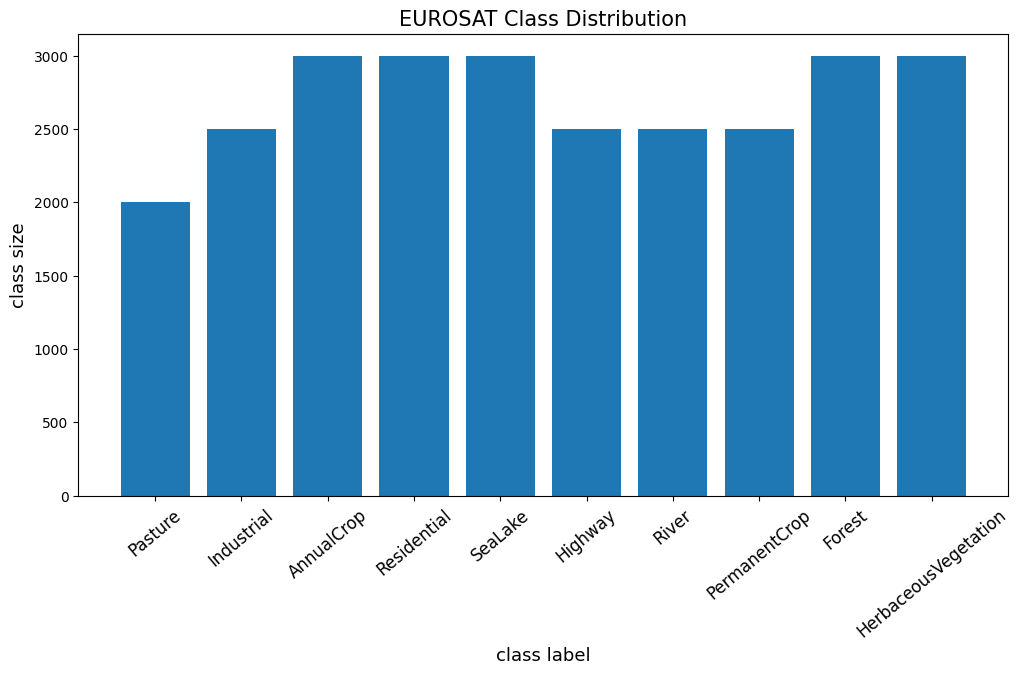

In [15]:
import matplotlib.pyplot as plt
import numpy as np

counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

2.3.4 Function that selects 5 random classes

In [16]:
# Randomly choose 5 classes

import random

def get_random_labels(LABELS):
  # Choose 5 random elements from the list
  random_LABELS = random.sample(LABELS, k=5)
  return random_LABELS

# Print the result
random_LABELS = get_random_labels(LABELS)
print(random_LABELS)

['AnnualCrop', 'Residential', 'Industrial', 'PermanentCrop', 'Highway']


2.3.5 Function that selects 22 random images from each class (110 in total): 25 for training, 75 for testing and 10 for validation

In [17]:
# Choose 25 images for train_dataset and 75 images for test_dataset
# Additionally, get 10 images for the val_dataset
# In total, 110 images will be extracted, 22 for each class

def get_data_dict(random_LABELS):

  # Create the dictionary that will store the images for every class

  data_dict = {}

  for l in random_LABELS:

    # Ensure unique random numbers using random.sample
    num_samples = 22
    random_numbers = random.sample(range(1, counts[l] + 1), num_samples)

    file_paths = [os.path.join(DATASET, l, f"{l}_{str(random_number)}.jpg") for random_number in random_numbers]

    data_dict[l] = file_paths

  return data_dict

data_dict = get_data_dict(random_LABELS)

print(data_dict)

{'AnnualCrop': ['EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_355.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_1200.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_1952.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_1595.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_1546.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_763.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_150.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_2453.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_2622.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_90.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_1509.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_1658.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_1130.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_118.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_1710.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_2651.jpg', 'EuroSAT_RGB/EuroSAT_RGB/AnnualCrop/AnnualCrop_2813.jpg', 'Eur

2.3.6 Function to extract and shuffle the designed number of images belonging to each of the labels for the training, the validation and the testing dataset

In [18]:
import random

def extract_data(data_dict):

  data = {
      'train':
      [],
      'val':
      [],
      'test':
      []
  }

  for key, value in data_dict.items():
    data["train"].extend([(v, key) for v in value[:5]])
    data["val"].extend([(v, key) for v in value[5:7]])
    data["test"].extend([(v, key) for v in value[7:]])

  random.shuffle(data["train"])
  random.shuffle(data["val"])
  random.shuffle(data["test"])

  return data

data = extract_data(data_dict)

print(len(data["train"]))
print(len(data["test"]))
print(len(data["val"]))

25
75
10


2.3.7 Class that initiates an instance of a custom Dataset that stores the data and retrieves it like a Map Dataset

In [19]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# Create a custom class
class CustomDataset(Dataset):
    def __init__(self, data, labels_map, transform):
        self.data = data
        self.labels_map = labels_map
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label_name = self.data[idx]

        # Read image
        image = Image.open(image_path)

        #transform
        img = self.transform(image)

        # Get label
        label_id = self.labels_map[label_name]
        label_id = torch.tensor(label_id)

        return img, label_id

2.3.8 The transform with the Imagenet normalization

In [20]:
from torchvision.transforms import v2

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #moving to tensor
    v2.Resize((224, 224), antialias=None), # Resizing to 224x224
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing
])

2.3.9 Function to get the datasets and the dataloaders from the data

In [21]:
def get_data(data, labels_map, transform):

  datasets = {
      "train":
      CustomDataset(data["train"], labels_map, transform),
      "val":
      CustomDataset(data["val"], labels_map, transform),
      "test":
      CustomDataset(data["test"], labels_map, transform),
  }

  dataloaders = {
      "train":
      DataLoader(datasets["train"], batch_size=5, shuffle=True),
      "val":
      DataLoader(datasets["val"], batch_size=5, shuffle=False),
      "test":
      DataLoader(datasets["test"], batch_size=5, shuffle=False)
  }

  return datasets, dataloaders

datasets, dataloaders = get_data(data, map, transform)

2.3.10 Show some images from the validation dataset

Feature batch shape: torch.Size([5, 3, 224, 224])
Labels batch shape: torch.Size([5])


<ipython-input-22-1537c4e68648>:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  img = imgs[0].T.numpy()


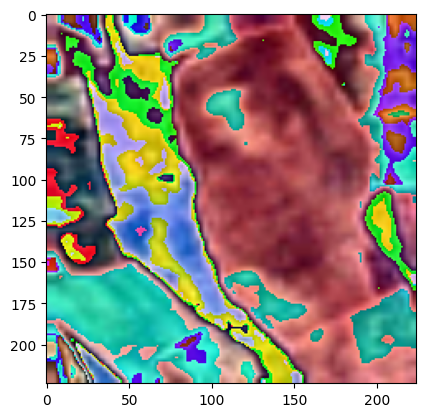

Label: 7
Feature batch shape: torch.Size([5, 3, 224, 224])
Labels batch shape: torch.Size([5])


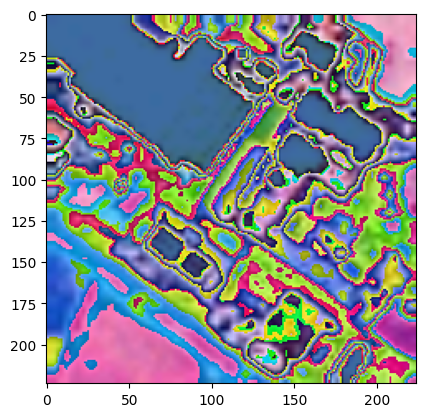

Label: 1


In [22]:
import matplotlib.pyplot as plt
#from matplotlib.colors import Normalize
import numpy as np

for imgs, labels in dataloaders["val"]:
  print(f"Feature batch shape: {imgs.size()}")
  print(f"Labels batch shape: {labels.size()}")
  img = imgs[0].T.numpy()
  label = labels[0]
  plt.imshow((img * 255).astype(np.uint8))
  plt.show()
  print(f"Label: {label}")

2.3.11 Function that loads the pre-trained model, freezes the initial layers and bootstraps a new "top" portion of the model (i.e. Fully-Connected and Output layers)

In [23]:
def get_pretrained_model(name, n_classes):

    model = vgg16(weights='IMAGENET1K_V1')
    model.classifier[-1] = nn.Linear(4096, 64)  # Change the output layer to match the number of classes

    model.load_state_dict(torch.load(name))

    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False
    n_inputs = model.classifier[6].in_features

    # Add on classifier
    model.classifier[6] = nn.Sequential(
        nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
        nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if torch.cuda.is_available():
        model = model.to('cuda')

    return model

2.3.12 Testing the VGG16 pre-trained model on 5 EuroSAT datasets

In [24]:
# For loop that iterates over multiple EuroSAT datasets

acc = []

num_loop = 5

for i in range(num_loop):
  # get random labels
  random_LABELS = get_random_labels(LABELS)

  labels_map = {string: index for index, string in enumerate(random_LABELS)}

  # get dictionary with data
  data_dict = get_data_dict(random_LABELS)

  # extract the data for training, validation and testing
  data = extract_data(data_dict)

  # get the datasets and the dataloaders
  datasets, dataloaders = get_data(data, labels_map, transform)

  # load the model
  model = get_pretrained_model('checkpoint.pt', len(random_LABELS))

  # define the name of the model
  name = 'EuroSAT' + str(i) + '.pt'

  # train and test the data
  acc.append(train_test_model(model, dataloaders["train"], dataloaders["val"], dataloaders["test"], name=name))

av_acc = sum(acc)/num_loop

print(f'Average accuracy on the test sets: {100 * av_acc}%')

Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.001000, accuracy: 0.280000, loss: 1.580095, valid accuracy: 0.500000
epoch: 1, lr: 0.001000, accuracy: 0.600000, loss: 1.086059, valid accuracy: 0.800000
epoch: 2, lr: 0.001000, accuracy: 0.840000, loss: 0.654242, valid accuracy: 0.700000
epoch: 3, lr: 0.001000, accuracy: 1.000000, loss: 0.233031, valid accuracy: 0.700000
epoch: 4, lr: 0.001000, accuracy: 1.000000, loss: 0.096400, valid accuracy: 0.700000
epoch: 5, lr: 0.001000, accuracy: 1.000000, loss: 0.052141, valid accuracy: 0.900000
epoch: 6, lr: 0.000100, accuracy: 1.000000, loss: 0.045662, valid accuracy: 0.900000
epoch: 7, lr: 0.000100, accuracy: 0.960000, loss: 0.237602, valid accuracy: 0.900000
epoch: 8, lr: 0.000100, accuracy: 1.000000, loss: 0.038117, valid accuracy: 0.900000
epoch: 9, lr: 0.000100, accuracy: 1.000000, loss: 0.016290, valid accuracy: 0.900000
epoch: 10, lr: 0.000100, accuracy: 1.000000, loss: 0.010062, valid accuracy: 0.900000
epoch: 11, lr

# 3. Evaluation on other datasets

Evaluation on other datasets such as CIFAR-10 (This part will be used as a bonus item, 2 points)

# 3.1 Evaluating the performance of the VGG16 model on the CIFAR-10 dataset

In [8]:
import tarfile

# Replace 'your_file.tar.gz' with the actual name of your tar.gz file
tar_file_path = 'cifar-10-python.tar.gz'
extract_path = 'cifar10'  # Adjust the destination directory

# Open the tar.gz file
with tarfile.open(tar_file_path, 'r:gz') as tar:
    # Extract all contents to the specified directory
    tar.extractall(path=extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to cifar10


In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [10]:
data_batch_1 = unpickle('cifar10/cifar-10-batches-py/data_batch_1')

In [11]:
print(data_batch_1.keys())

dict_keys(['batch_label', 'labels', 'data', 'filenames'])


In [12]:
meta_data = unpickle('cifar10/cifar-10-batches-py/batches.meta')

3.1.1 Displaying some images from the CIFAR-10 dataset

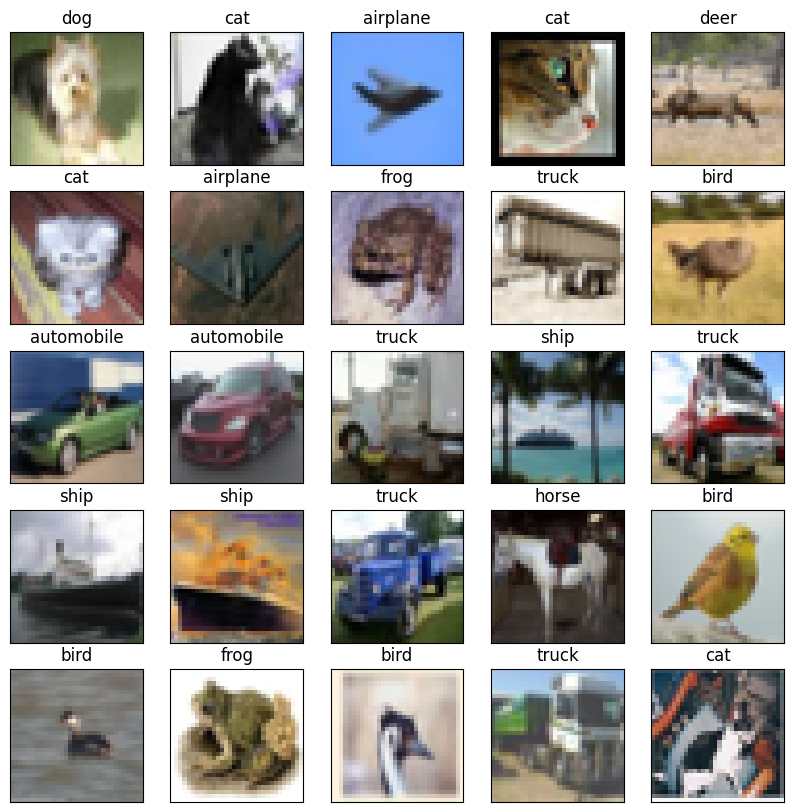

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# take the images data from batch data
images = data_batch_1['data']
# reshape and transpose the images
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)
# take labels of the images
labels = data_batch_1['labels']
# label names of the images
label_names = meta_data['label_names']

# dispaly random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
# take labels for these images only
labels = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()

In [14]:
X_train = data_batch_1['data']
print("Shape before reshape:", X_train.shape)

Shape before reshape: (10000, 3072)


In [15]:
train_labels = data_batch_1['labels']
print("Shape of labels:", len(train_labels))

Shape of labels: 10000


In [16]:
# Reshape the whole image data
X_train = X_train.reshape(len(X_train),3,32,32)
print("Shape after reshape:", X_train.shape)

Shape after reshape: (10000, 3, 32, 32)


3.1.2 Class that creates a CIFAR-10 dataset

In [30]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# Create a custom class
class CIFAR10Dataset(Dataset):
    def __init__(self, data, transform, labels_map):
        self.data = data
        self.transform = transform
        self.labels_map = labels_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label_id = self.data[idx]

        image = image.reshape(3,32,32)

        image = torch.from_numpy(image)

        #transform
        img = self.transform(image)

        # Get label
        label_id = self.labels_map[label_id]
        label_id = torch.tensor(label_id)

        return img, label_id

3.1.3 The transform without any data augmentation

In [31]:
from torchvision.transforms import v2

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #moving to tensor
    v2.Resize((224, 224), antialias=None), # Resizing to 224x224
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing
])

transform_orig = {
      'train':
      transform,
      'val':
      transform,
      'test':
      transform,
  }

3.1.4 Function to get the indexes corresponding to each label

In [32]:
def indexes_CF10(labels):
  indexes_each_label = {}

  for index, label in enumerate(labels):

    if label not in indexes_each_label:
      indexes_each_label[label] = [index]

    else:
      indexes_each_label[label].append(index)

  return indexes_each_label

dict_indexes = indexes_CF10(train_labels)

print(dict_indexes)

{6: [0, 19, 22, 23, 25, 72, 95, 103, 104, 117, 124, 125, 132, 143, 151, 154, 164, 187, 200, 204, 209, 210, 224, 228, 231, 232, 234, 235, 242, 243, 245, 248, 249, 286, 292, 298, 313, 326, 327, 347, 350, 351, 355, 361, 368, 387, 409, 437, 451, 452, 464, 473, 488, 525, 529, 532, 552, 556, 571, 587, 588, 591, 619, 620, 625, 633, 640, 645, 651, 655, 667, 680, 682, 692, 710, 718, 720, 721, 728, 738, 745, 755, 770, 781, 807, 818, 819, 836, 837, 838, 854, 862, 863, 896, 899, 903, 914, 920, 921, 923, 929, 931, 935, 937, 960, 961, 985, 1013, 1016, 1017, 1023, 1027, 1031, 1035, 1038, 1047, 1051, 1053, 1063, 1085, 1101, 1126, 1131, 1132, 1154, 1155, 1159, 1161, 1175, 1176, 1191, 1192, 1194, 1210, 1220, 1222, 1228, 1237, 1246, 1248, 1259, 1317, 1318, 1327, 1342, 1360, 1362, 1367, 1371, 1374, 1393, 1402, 1403, 1420, 1436, 1447, 1453, 1484, 1485, 1529, 1531, 1536, 1537, 1550, 1552, 1563, 1579, 1584, 1585, 1596, 1613, 1627, 1628, 1635, 1637, 1642, 1646, 1678, 1687, 1690, 1722, 1730, 1733, 1741, 1743, 

3.1.5 Function to choose 5 random labels

In [33]:
import random

def random_labels_CIFAR10():
  random_numbers = random.sample(range(10), 5)
  return random_numbers

print(random_labels_CIFAR10())

[2, 9, 3, 6, 8]


3.1.6 Function to map the different labels between the range 0-4

In [34]:
labels_map = {label: index for index, label in enumerate(random_labels_CIFAR10())}

print(labels_map)

{9: 0, 0: 1, 4: 2, 7: 3, 8: 4}


3.1.7 Function to get the dataloaders for the training, the validation and the test set

In [36]:
def get_dataloaders_CIFAR10(dict_indexes, transform, data):

  subset_labels = random_labels_CIFAR10()

  labels_map = {label: index for index, label in enumerate(subset_labels)}

  data_CIFAR10 = {
      'train':
      [],
      'val':
      [],
      'test':
      []
  }

  for key, value in dict_indexes.items():

    if key in subset_labels:
      value_chosen = random.sample(value, 22)

      data_CIFAR10["train"].extend([(data[v], key) for v in value_chosen[:5]])
      data_CIFAR10["val"].extend([(data[v], key) for v in value_chosen[5:7]])
      data_CIFAR10["test"].extend([(data[v], key) for v in value_chosen[7:]])

  random.shuffle(data_CIFAR10["train"])
  random.shuffle(data_CIFAR10["val"])
  random.shuffle(data_CIFAR10["test"])

  datasets_CIFAR10 = {
    "train":
    CIFAR10Dataset(data_CIFAR10["train"], transform["train"], labels_map),
    "val":
    CIFAR10Dataset(data_CIFAR10["val"], transform["val"], labels_map),
    "test":
    CIFAR10Dataset(data_CIFAR10["test"], transform["test"], labels_map),
  }

  dataloaders_CIFAR10 = {
    "train":
    DataLoader(datasets_CIFAR10["train"], batch_size=5, shuffle=True),
    "val":
    DataLoader(datasets_CIFAR10["val"], batch_size=5, shuffle=False),
    "test":
    DataLoader(datasets_CIFAR10["test"], batch_size=5, shuffle=False)
  }

  return dataloaders_CIFAR10

dataloaders_CIFAR10 = get_dataloaders_CIFAR10(dict_indexes, transform_orig, data_batch_1['data'])

3.1.8 Display some images from the dataloaders

Feature batch shape: torch.Size([5, 3, 224, 224])
Labels batch shape: torch.Size([5])


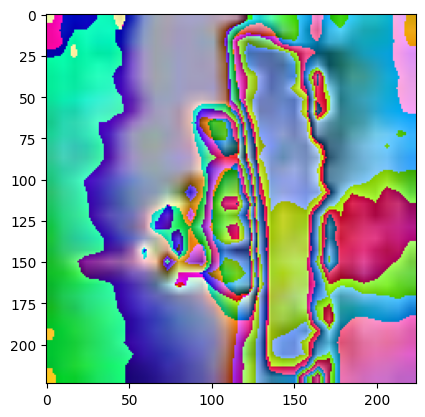

Label: 0
Feature batch shape: torch.Size([5, 3, 224, 224])
Labels batch shape: torch.Size([5])


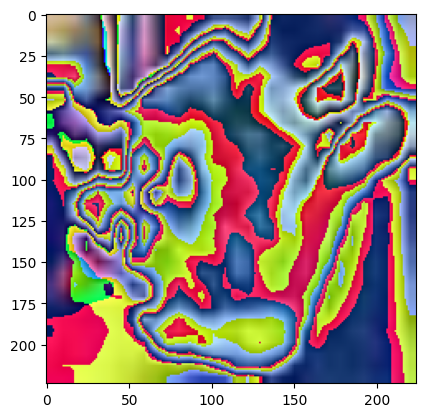

Label: 3


In [37]:
import matplotlib.pyplot as plt
#from matplotlib.colors import Normalize
import numpy as np

for imgs, labels in dataloaders_CIFAR10["val"]:
  print(f"Feature batch shape: {imgs.size()}")
  print(f"Labels batch shape: {labels.size()}")
  img = imgs[0].T.numpy()
  label = labels[0]
  plt.imshow((img * 255).astype(np.uint8))
  plt.show()
  print(f"Label: {label}")

3.1.9 Function to calculate the accuracy of different datasets created from the original CIFAR-10 dataset

In [38]:
def accuracy_CIFAR10_subset(num_loop, data_list, labels_list, transform):

  # For loop that iterates over multiple CIFAR10 datasets

  acc = []

  for i in range(num_loop):
    # get the indexes corresponding to each label
    dict_indexes = indexes_CF10(labels_list)

    # get the dataloaders
    dataloaders_CIFAR10 = get_dataloaders_CIFAR10(dict_indexes, transform, data_list)

    # load the model
    model = get_pretrained_model('checkpoint.pt', 5)

    # define the name of the model
    name = 'CIFAR-10-' + str(i) + '.pt'

    # train and test the data
    acc.append(train_test_model(model, dataloaders_CIFAR10["train"], dataloaders_CIFAR10["val"], dataloaders_CIFAR10["test"], name=name))

  av_acc = sum(acc)/num_loop

  print(f'Average accuracy on the test sets: {100 * av_acc}%')

  return

In [39]:
from torchvision.models import vgg16

3.1.10 Calculate the accuracy of 5 random CIFAR-10 subsets without data augmentation

In [40]:
accuracy_CIFAR10_subset(5, data_batch_1['data'], data_batch_1['labels'], transform_orig)

Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.001000, accuracy: 0.120000, loss: 2.018189, valid accuracy: 0.400000
epoch: 1, lr: 0.001000, accuracy: 0.240000, loss: 1.452109, valid accuracy: 0.600000
epoch: 2, lr: 0.001000, accuracy: 0.720000, loss: 1.108870, valid accuracy: 0.500000
epoch: 3, lr: 0.001000, accuracy: 0.680000, loss: 0.596012, valid accuracy: 0.500000
epoch: 4, lr: 0.001000, accuracy: 0.800000, loss: 1.152648, valid accuracy: 0.500000
epoch: 5, lr: 0.001000, accuracy: 0.920000, loss: 0.076862, valid accuracy: 0.500000
epoch: 6, lr: 0.000100, accuracy: 0.920000, loss: 0.113893, valid accuracy: 0.500000
epoch: 7, lr: 0.000100, accuracy: 0.920000, loss: 0.087505, valid accuracy: 0.500000
epoch: 8, lr: 0.000100, accuracy: 0.960000, loss: 0.214030, valid accuracy: 0.500000
epoch: 9, lr: 0.000100, accuracy: 0.880000, loss: 0.248105, valid accuracy: 0.500000
epoch: 10, lr: 0.000100, accuracy: 1.000000, loss: 0.148539, valid accuracy: 0.500000
Early stoppin

3.1.11 Transform with data augmentation

In [41]:
from torchvision.transforms import v2

transform_augmentation = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_aug = {
      'train':
      transform_augmentation,
      'val':
      transform,
      'test':
      transform,
  }

3.1.12 Calculate the accuracy of 5 random CIFAR-10 subsets with data augmentation

In [45]:
accuracy_CIFAR10_subset(5, data_batch_1['data'], data_batch_1['labels'], transform_aug)

Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.001000, accuracy: 0.240000, loss: 1.671926, valid accuracy: 0.300000
epoch: 1, lr: 0.001000, accuracy: 0.160000, loss: 1.954959, valid accuracy: 0.400000
epoch: 2, lr: 0.001000, accuracy: 0.400000, loss: 1.201025, valid accuracy: 0.400000
epoch: 3, lr: 0.001000, accuracy: 0.560000, loss: 1.588383, valid accuracy: 0.200000
epoch: 4, lr: 0.001000, accuracy: 0.440000, loss: 1.902452, valid accuracy: 0.400000
epoch: 5, lr: 0.001000, accuracy: 0.520000, loss: 1.228018, valid accuracy: 0.400000
epoch: 6, lr: 0.000100, accuracy: 0.640000, loss: 0.753152, valid accuracy: 0.500000
epoch: 7, lr: 0.000100, accuracy: 0.640000, loss: 0.213460, valid accuracy: 0.500000
epoch: 8, lr: 0.000100, accuracy: 0.600000, loss: 0.437245, valid accuracy: 0.600000
epoch: 9, lr: 0.000100, accuracy: 0.640000, loss: 1.180571, valid accuracy: 0.500000
epoch: 10, lr: 0.000100, accuracy: 0.760000, loss: 0.443995, valid accuracy: 0.500000
epoch: 11, lr